# Analyzing Quasar Spectra with Dimensionality Reduction and Clustering

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapters 10-11 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

Quasars represent some of the most energetic phenomena in the universe—supermassive black holes actively accreting matter at the centers of distant galaxies. These cosmic beacons, visible across billions of light-years, serve as powerful probes of both fundamental physics and cosmological evolution. As material spirals into the black hole through an accretion disk, it reaches temperatures of millions of degrees, producing intense radiation that spans the electromagnetic spectrum from radio waves to gamma rays.

The spectroscopic signatures of quasars encode a wealth of astrophysical information. The continuum emission from the accretion disk follows a multi-temperature blackbody distribution, modified by relativistic effects near the black hole. Superimposed on this continuum are broad emission lines from gas clouds orbiting at thousands of kilometers per second in the broad-line region. When this light traverses the vast distances between quasar and observer, it encounters intervening matter—neutral hydrogen in the intergalactic medium creates the Lyman-α forest of absorption features, while metal-enriched gas in galaxy halos produces additional absorption systems. Each spectrum thus contains information not only about the quasar itself but also about billions of years of cosmic evolution along the line of sight.

Modern spectroscopic surveys have revolutionized our understanding of quasars by providing high-quality spectra for millions of these objects. The Sloan Digital Sky Survey (SDSS) alone has cataloged over 700,000 quasar spectra, while upcoming surveys like the Dark Energy Spectroscopic Instrument (DESI) aim to observe millions more. This data deluge presents both opportunities and challenges: while we have unprecedented statistical power to study quasar populations, the high dimensionality of spectral data—often thousands of wavelength bins per spectrum—makes traditional analysis methods computationally prohibitive.

This challenge motivates our exploration of dimensionality reduction techniques. The key insight is that despite their apparent complexity, quasar spectra are governed by a relatively small number of physical parameters. The black hole mass, accretion rate, viewing angle, and chemical composition largely determine the observed spectral properties. This suggests that the thousands-dimensional space of raw spectra can be efficiently compressed to a much lower-dimensional representation without significant information loss.

In this tutorial, we develop a comprehensive framework combining unsupervised learning techniques to analyze quasar spectra. We begin with Principal Component Analysis (PCA) to identify the dominant modes of spectral variation and achieve efficient data compression. We then apply Gaussian Mixture Models (GMM) to characterize the distribution of quasars in this reduced parameter space. This combination enables us to build generative models for creating realistic synthetic spectra and implement robust outlier detection to identify unusual objects worthy of follow-up study. Throughout, we emphasize the physical interpretation of our statistical findings, connecting mathematical results to the underlying astrophysics.

## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Python Programming**: Proficiency with NumPy arrays, matplotlib visualization, and scipy functionality
- **Linear Algebra**: Understanding of matrix operations, eigenvalue decomposition, and orthogonal transformations
- **Statistical Concepts**: Knowledge of covariance matrices, multivariate Gaussian distributions, and maximum likelihood estimation
- **Chapter 10 Material**: The mathematical foundations of PCA, including the optimization framework and its connection to eigendecomposition
- **Chapter 11 Material**: The theoretical framework of Gaussian Mixture Models, including the EM algorithm

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Spectral Analysis**: Applying dimensionality reduction to high-resolution astronomical spectra and interpreting the physical meaning of principal components
- **Compression Strategies**: Quantifying the trade-off between data compression and reconstruction fidelity for large spectroscopic surveys
- **Distribution Modeling**: Characterizing complex populations in reduced parameter spaces using mixture models
- **Generative Techniques**: Creating synthetic spectra that preserve the statistical properties of observed quasar populations
- **Anomaly Detection**: Implementing likelihood-based methods to identify rare or unusual objects in high-dimensional datasets
- **Physical Interpretation**: Connecting statistical patterns to the underlying physics of black hole accretion and quasar emission

We begin by importing the necessary libraries and configuring our computational environment:


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## The Quasar Spectral Dataset

Our analysis centers on a carefully curated dataset of quasar continuum spectra. These spectra have undergone sophisticated preprocessing to isolate the smooth continuum emission from the complex absorption features typically present in quasar observations. The continuum—produced by thermal emission from the accretion disk surrounding the supermassive black hole—encodes fundamental information about the quasar's physical properties.

The preprocessing removes the Lyman-α forest, a dense series of absorption lines created by neutral hydrogen along the line of sight. While these absorption features provide valuable cosmological information, their removal allows us to focus on the intrinsic emission properties of the quasars themselves. Similarly, metal absorption lines from intervening galaxies have been excised, leaving us with clean continua that reveal the underlying physics of the accretion process.

Each spectrum in our dataset spans 2,947 wavelength bins covering the rest-frame ultraviolet and optical regions where quasars emit most strongly. This wavelength range captures key diagnostic features including the Lyman-α emission line at 1215 Å, the C IV line at 1549 Å, and other prominent emission features that arise from gas in the broad-line region surrounding the black hole.

Let's load the dataset and explore its structure:

In [42]:
# Load the quasar spectral dataset
data = np.load("dataset_quasar_sample.npz")
X = data["continua"]
wavelength = data["wavelength"]

print("Dataset contents:", data.files)
print(f"Spectral data shape: {X.shape}")
print(f"Number of quasars: {X.shape[0]}")
print(f"Number of wavelength bins: {X.shape[1]}")
print(f"Wavelength coverage: {wavelength.min():.1f} - {wavelength.max():.1f} Å")

# Calculate basic statistics
print(f"\nFlux statistics:")
print(f"Min flux value: {np.min(X):.3f}")
print(f"Max flux value: {np.max(X):.3f}")
print(f"Mean flux: {np.mean(X):.3f} ± {np.std(X):.3f}")

Dataset contents: ['continua', 'wavelength']
Spectral data shape: (1000, 2947)
Number of quasars: 1000
Number of wavelength bins: 2947
Wavelength coverage: 1030.0 - 2029.7 Å

Flux statistics:
Min flux value: 0.218
Max flux value: 10.879
Mean flux: 1.062 ± 0.574


### Visualizing Representative Quasar Continua

To understand the structure of our data, let's examine several representative quasar continua. It's important to note that these spectra have already been processed to extract only the continuum emission—the smooth underlying spectrum produced by the accretion disk. The complex absorption features from the Lyman-α forest and metal lines have been removed, allowing us to focus on the fundamental emission properties of the quasars themselves.

The continuum emission arises from the accretion disk surrounding the supermassive black hole. As material spirals inward, viscous heating creates a multi-temperature blackbody spectrum. The innermost regions near the black hole reach temperatures exceeding $10^5$ K, producing UV emission, while cooler outer regions contribute optical light. This temperature gradient, combined with relativistic effects and disk geometry, shapes the observed continuum.

Superimposed on this continuum are broad emission lines from gas clouds in the broad-line region (BLR). These clouds, photoionized by the intense UV radiation from the accretion disk, orbit the black hole at velocities of thousands of kilometers per second. The Doppler broadening from these high velocities creates the characteristic broad profiles that give these features their name. The most prominent lines include Lyman-α (1215 Å) from hydrogen and C IV (1549 Å) from triply-ionized carbon, along with numerous other ionic transitions that probe different ionization zones within the BLR.

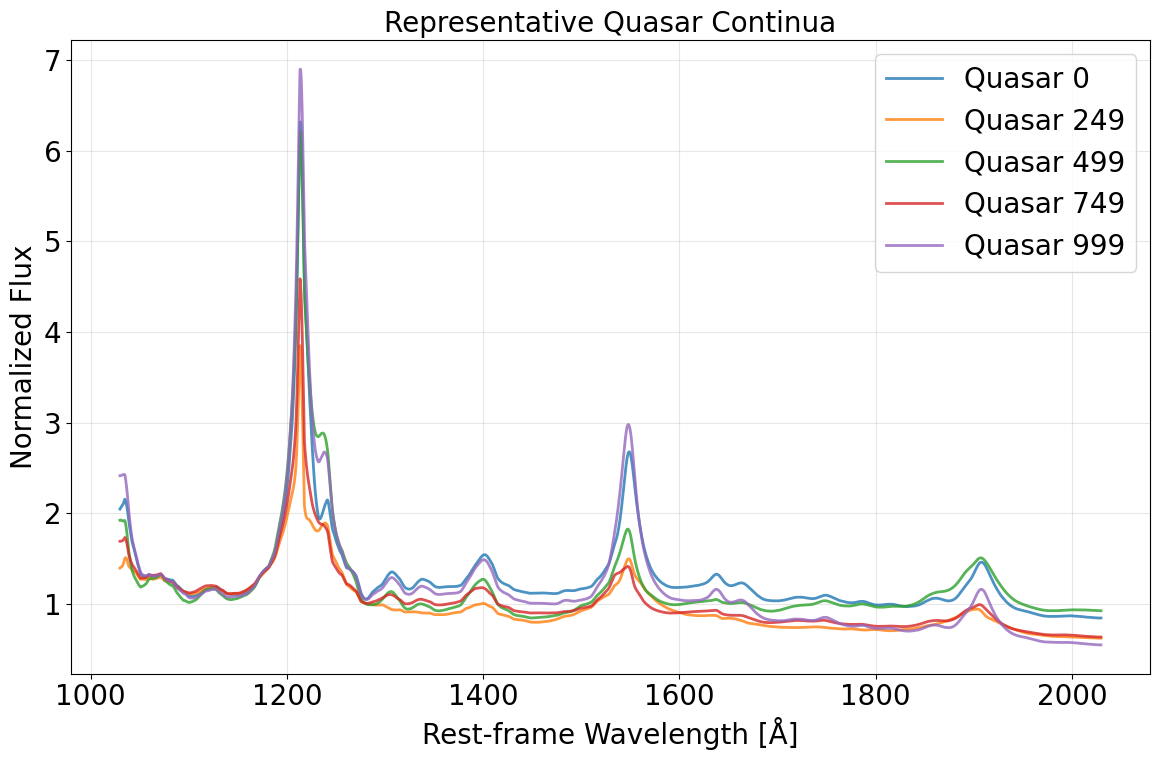

In [43]:
# Plot a selection of quasar continua
fig, ax = plt.subplots(figsize=(12, 8))

# Select every 200th spectrum to show variety without overcrowding
n_examples = 5
indices = np.linspace(0, len(X)-1, n_examples, dtype=int)

for i, idx in enumerate(indices):
    ax.plot(wavelength, X[idx], alpha=0.8, linewidth=2, 
            label=f'Quasar {idx}')

ax.set_xlabel('Rest-frame Wavelength [Å]')
ax.set_ylabel('Normalized Flux')
ax.set_title('Representative Quasar Continua')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The plot above displays several representative quasar continua from our dataset. Each curve represents a different quasar's continuum spectrum, showing how the flux varies across different wavelengths. Several important features are evident:

**Lyman-α Emission Line**: The prominent peak around 1215 Å is the Lyman-α emission line, one of the strongest features in quasar spectra. This emission occurs when electrons in hydrogen atoms transition from the n=2 to n=1 energy level in the broad-line region surrounding the black hole.

**Power-Law Continuum**: The underlying continuum shape follows an approximate power law, produced by the multi-temperature blackbody emission from the accretion disk. The spectral slope encodes information about the accretion rate and black hole mass.

**Other Emission Features**: Additional peaks at longer wavelengths correspond to other emission lines, including C IV (1549 Å) and other metal transitions. These features provide diagnostics of the gas temperature, density, and metallicity in the quasar environment.

It's crucial to understand that these are simulated continua generated from models with a finite number of parameters for pedagogical purposes. This makes them somewhat idealized compared to real observations. While they capture the primary modes of variation in quasar spectra, real continua would exhibit additional subtle variabilities from instrumental effects, atmospheric variations, and small-scale physical processes not captured in the simulations. This controlled nature actually benefits our analysis—it allows us to test dimensionality reduction techniques on data where we expect a relatively small number of principal components to capture most of the variance.

The high dimensionality of these spectra (2,947 wavelength bins) presents both a computational challenge and an opportunity. Since these are simulated from a model with limited degrees of freedom, we expect Principal Component Analysis to achieve very efficient compression—potentially reducing thousands of dimensions to just a handful while preserving the essential information. This makes the dataset ideal for demonstrating the power of dimensionality reduction in astronomy.

## Principal Component Analysis for Spectral Compression

Principal Component Analysis (PCA) provides a powerful framework for analyzing high-dimensional spectral data. By identifying the directions of maximum variance in our dataset, PCA can reveal the fundamental patterns that characterize quasar spectra while achieving dramatic data compression.

Each quasar spectrum in our dataset contains 2,947 flux measurements. Storing and analyzing such high-dimensional data presents significant computational challenges, especially when dealing with millions of spectra from modern surveys. However, the physics of quasar emission suggests that the intrinsic dimensionality is much lower. The continuum shape is primarily determined by a few key parameters: the black hole mass, accretion rate, viewing angle, and dust extinction. Similarly, emission line strengths depend on the ionization state and kinematics of the broad-line region.

PCA exploits this structure by finding a new coordinate system where the data variance is concentrated along a small number of axes. These principal components often have clear physical interpretations, making PCA not just a compression tool but also a method for understanding the underlying physics.

### Mathematical Foundation of PCA

For our dataset with $N$ quasar spectra $\{\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N\}$, where each spectrum is represented as a row vector in $\mathbb{R}^D$ with $D = 2947$ wavelength bins, PCA seeks to find orthogonal directions that maximize variance. The procedure involves:

1. **Centering the data**: Computing the mean spectrum $\bar{\mathbf{x}} = \frac{1}{N}\sum_{n=1}^{N}\mathbf{x}_n$ and centering each spectrum: $\tilde{\mathbf{x}}_n = \mathbf{x}_n - \bar{\mathbf{x}}$

2. **Finding principal components**: The directions that maximize variance are the eigenvectors of the covariance matrix. However, for computational efficiency with high-dimensional data, we use Singular Value Decomposition (SVD) directly on the centered data matrix.

3. **Projecting onto components**: Each spectrum can be represented by its projection coefficients onto the principal components, dramatically reducing dimensionality while preserving the most important variations.

### Implementing PCA with Singular Value Decomposition

Let's implement PCA from scratch using Singular Value Decomposition (SVD), which provides a numerically stable and efficient approach for high-dimensional data. The SVD decomposes our centered data matrix $\mathbf{X} \in \mathbb{R}^{N \times D}$ as:

$$\mathbf{X} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^T$$

where $\mathbf{U} \in \mathbb{R}^{N \times N}$ contains the left singular vectors, $\mathbf{\Sigma} \in \mathbb{R}^{N \times D}$ is a diagonal matrix of singular values, and $\mathbf{V} \in \mathbb{R}^{D \times D}$ contains the right singular vectors. The columns of $\mathbf{V}$ are our principal components—the directions in wavelength space along which our quasar spectra show the most variation.

In [44]:
def pca_svd(X, n_components=None):
    """
    Perform Principal Component Analysis using SVD
    
    Parameters:
    -----------
    X : numpy.ndarray, shape (n_samples, n_features)
        The input data matrix
    n_components : int or None
        Number of components to keep. If None, keep all components
        
    Returns:
    --------
    X_mean : numpy.ndarray, shape (n_features,)
        The mean of the training data
    components : numpy.ndarray, shape (n_components, n_features)
        The principal components (eigenvectors)
    explained_variance : numpy.ndarray, shape (n_components,)
        The variance explained by each component
    explained_variance_ratio : numpy.ndarray, shape (n_components,)
        The percentage of variance explained by each component
    U : numpy.ndarray
        Left singular vectors
    S : numpy.ndarray
        Singular values
    Vt : numpy.ndarray
        Right singular vectors (transposed)
    """
    # Center the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # Perform SVD
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    
    # Calculate explained variance
    n_samples = X.shape[0]
    explained_variance = (S ** 2) / (n_samples - 1)
    total_variance = np.sum(explained_variance)
    explained_variance_ratio = explained_variance / total_variance
    
    # Select components if specified
    if n_components is not None:
        U = U[:, :n_components]
        S = S[:n_components]
        Vt = Vt[:n_components]
        explained_variance = explained_variance[:n_components]
        explained_variance_ratio = explained_variance_ratio[:n_components]
    
    components = Vt
    
    return X_mean, components, explained_variance, explained_variance_ratio, U, S, Vt


### Understanding the Variance Decomposition

The Singular Value Decomposition provides more than just a matrix factorization—it directly connects to the variance structure of our data. The singular values in $\mathbf{\Sigma}$ relate to the eigenvalues of the covariance matrix, which in turn quantify the variance along each principal component direction.

Specifically, for a centered data matrix $\mathbf{X}$ with $N$ samples, the eigenvalues $\lambda_i$ of the covariance matrix are related to the singular values $\sigma_i$ by:

$$\lambda_i = \frac{\sigma_i^2}{N}$$

Each eigenvalue represents the variance captured by its corresponding principal component. The fraction of total variance explained by the $i$-th component is:

$$\text{variance explained}_i = \frac{\lambda_i}{\sum_j \lambda_j} = \frac{\sigma_i^2}{\sum_j \sigma_j^2}$$

The cumulative variance curve—the running sum of these fractions—reveals how many components we need to retain a desired percentage of the total spectral information. This analysis is crucial for applications where we must balance data compression against scientific fidelity. For spectroscopic surveys, we might require 99% variance retention for precise redshift measurements, while 90% might suffice for basic spectral classification.

The distribution of variance across components also provides insight into the intrinsic dimensionality of our data. A steep initial rise followed by a gradual plateau indicates that quasar spectra are effectively low-dimensional—most variation can be captured with relatively few components. This behavior contrasts with truly high-dimensional data like random noise, where variance would be distributed more evenly across all components.

In [45]:
# Apply PCA to the quasar spectra
X_mean, components, explained_variance, explained_variance_ratio, U, S, Vt = pca_svd(X)

# Calculate cumulative variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print(f"Data shape: {X.shape}")
print(f"Number of principal components: {len(components)}")
print(f"\nVariance explained by first 10 components:")
for i in range(10):
    print(f"  PC{i+1}: {explained_variance_ratio[i]*100:.2f}%")
print(f"\nCumulative variance (first 10): {cumulative_variance_ratio[9]*100:.2f}%")

# Find how many components needed for different thresholds
thresholds = [0.90, 0.95, 0.99, 0.999]
for threshold in thresholds:
    n_comp = np.argmax(cumulative_variance_ratio >= threshold) + 1
    print(f"Components needed for {threshold*100:.1f}% variance: {n_comp}")

Data shape: (1000, 2947)
Number of principal components: 1000

Variance explained by first 10 components:
  PC1: 66.17%
  PC2: 20.93%
  PC3: 5.92%
  PC4: 2.47%
  PC5: 1.55%
  PC6: 1.40%
  PC7: 0.84%
  PC8: 0.72%
  PC9: 0.00%
  PC10: 0.00%

Cumulative variance (first 10): 100.00%
Components needed for 90.0% variance: 3
Components needed for 95.0% variance: 4
Components needed for 99.0% variance: 7
Components needed for 99.9% variance: 8


A key step in PCA is determining how many components to retain. By examining the cumulative variance explained, we can identify the point of diminishing returns where additional components contribute negligible information:


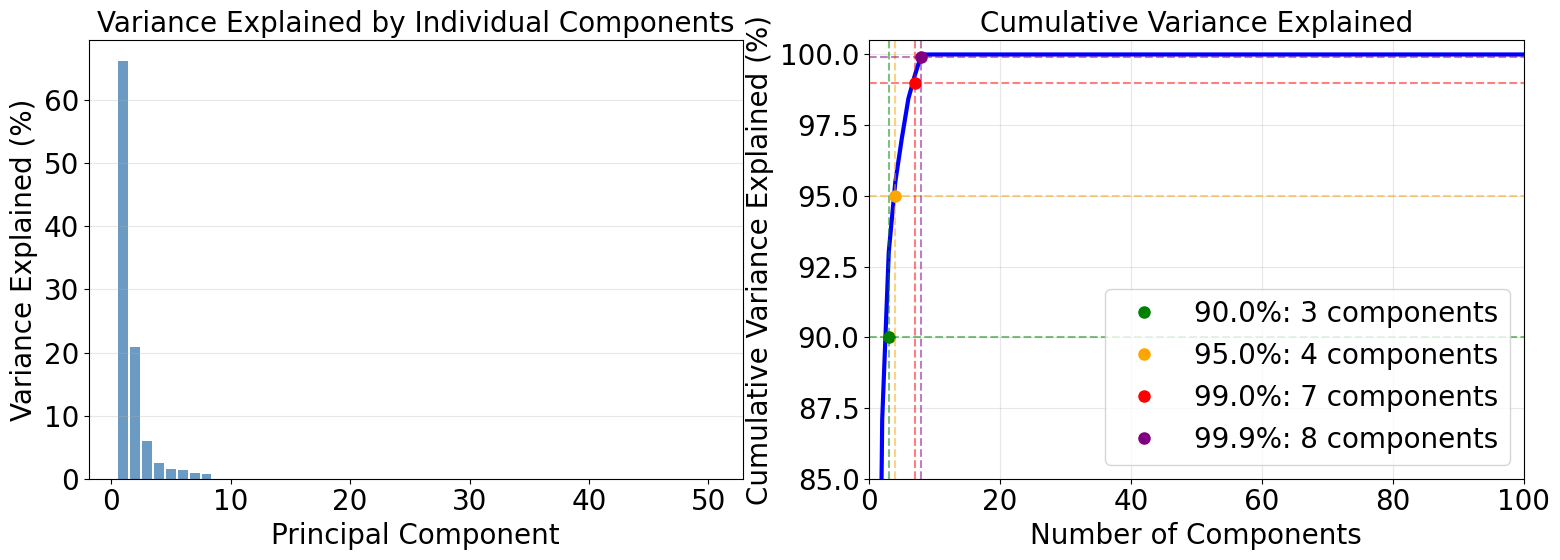

To capture 90.0% variance: 3 components needed (compression ratio: 982.3x)
To capture 95.0% variance: 4 components needed (compression ratio: 736.8x)
To capture 99.0% variance: 7 components needed (compression ratio: 421.0x)
To capture 99.9% variance: 8 components needed (compression ratio: 368.4x)


In [46]:
# Plot the cumulative variance explained
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: Individual variance explained by each component
n_components_to_show = 50
ax1.bar(range(1, n_components_to_show + 1), 
        explained_variance_ratio[:n_components_to_show] * 100, 
        color='steelblue', alpha=0.8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('Variance Explained by Individual Components')
ax1.grid(True, alpha=0.3, axis='y')

# Right panel: Cumulative variance explained
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), 
         cumulative_variance_ratio * 100, 
         'b-', linewidth=3)

# Mark key thresholds
thresholds = [0.90, 0.95, 0.99, 0.999]
colors = ['green', 'orange', 'red', 'purple']
for threshold, color in zip(thresholds, colors):
    n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
    ax2.axhline(threshold * 100, color=color, linestyle='--', alpha=0.5)
    ax2.axvline(n_components, color=color, linestyle='--', alpha=0.5)
    ax2.plot(n_components, threshold * 100, 'o', color=color, markersize=8,
             label=f'{threshold*100:.1f}%: {n_components} components')

ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained (%)')
ax2.set_title('Cumulative Variance Explained')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 100)
ax2.set_ylim(85, 100.5)

plt.tight_layout()
plt.show()

# Print summary statistics
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
    compression_ratio = X.shape[1] / n_components
    print(f"To capture {threshold*100:.1f}% variance: {n_components} components needed "
          f"(compression ratio: {compression_ratio:.1f}x)")


The variance analysis reveals the extraordinary compressibility of these quasar spectra. The results are striking: just 3 components capture 90% of the variance, and only 8 components are needed to capture 99.9%. This represents compression ratios of nearly 1000× while preserving the essential information. Such extreme efficiency confirms that these simulated spectra were indeed generated from a low-dimensional model.

For comparison, real observational data would typically require more components due to instrumental noise, atmospheric effects, and additional physical variations not captured in the simulations. Nevertheless, even real quasar spectra can often be well-represented with dozens of components—still a dramatic reduction from thousands of wavelength bins.

This efficient compression has profound practical implications. For large spectroscopic surveys containing millions of spectra, storing just 8 PCA coefficients per object instead of 2,947 flux values reduces storage requirements by a factor of 368 while preserving 99.9% of the information. This enables entire surveys to be kept in memory for rapid analysis, transforming what would be a big data problem into a manageable one.

The steep initial decline in the variance explained by individual components reflects the hierarchical nature of spectral variations. The first component captures the dominant mode—likely overall normalization or continuum shape. Subsequent components encode progressively more subtle features like emission line strengths, continuum slopes, and line ratios. This ordering ensures that even aggressive compression (using just the first few components) preserves the most important spectral characteristics.

### Reconstructing Spectra from Principal Components

To evaluate the quality of PCA compression, let's reconstruct spectra using different numbers of components and examine the trade-off between compression ratio and reconstruction accuracy. The reconstruction process provides intuitive insight into what information is preserved and what is lost at different compression levels.

For a spectrum $\mathbf{x}$, we first center it by subtracting the mean: $\tilde{\mathbf{x}} = \mathbf{x} - \bar{\mathbf{x}}$. The projection onto $M$ principal components gives us coefficients:

$$\mathbf{z} = \tilde{\mathbf{x}}\mathbf{V}_M^T$$

where $\mathbf{V}_M$ contains the first $M$ principal components. The reconstruction is then:

$$\hat{\mathbf{x}} = \mathbf{z}\mathbf{V}_M + \bar{\mathbf{x}} = \tilde{\mathbf{x}}\mathbf{V}_M\mathbf{V}_M^T + \bar{\mathbf{x}}$$

The matrix product $\mathbf{V}_M\mathbf{V}_M^T$ acts as a projection operator, keeping only the components of the spectrum that lie in the $M$-dimensional subspace spanned by the retained principal components. As $M$ approaches the full dimensionality, this projection becomes the identity operation, and we recover the original spectrum exactly.

Given the extreme efficiency we've observed, we'll test reconstructions with very few components to understand how spectral information is hierarchically encoded:

In [47]:
# Select a test spectrum to reconstruct
test_idx = 100
test_spectrum = X[test_idx]
test_spectrum_centered = test_spectrum - X_mean

# Calculate PCA coefficients for this spectrum
# Project onto the principal components
pca_coefficients = test_spectrum_centered @ components.T

# Reconstruct using different numbers of components
# Given the extreme efficiency, we'll use very few components
n_components_list = [1, 3, 5, 8]
reconstructions = {}
mse_values = {}

for n_comp in n_components_list:
    # Reconstruct using first n_comp components
    reconstruction_centered = pca_coefficients[:n_comp] @ components[:n_comp]
    reconstruction = reconstruction_centered + X_mean
    reconstructions[n_comp] = reconstruction
    
    # Calculate mean squared error
    mse = np.mean((test_spectrum - reconstruction)**2)
    mse_values[n_comp] = mse
    
    print(f"MSE with {n_comp} components: {mse:.6f}")

MSE with 1 components: 0.006227
MSE with 3 components: 0.005852
MSE with 5 components: 0.000338
MSE with 8 components: 0.000000


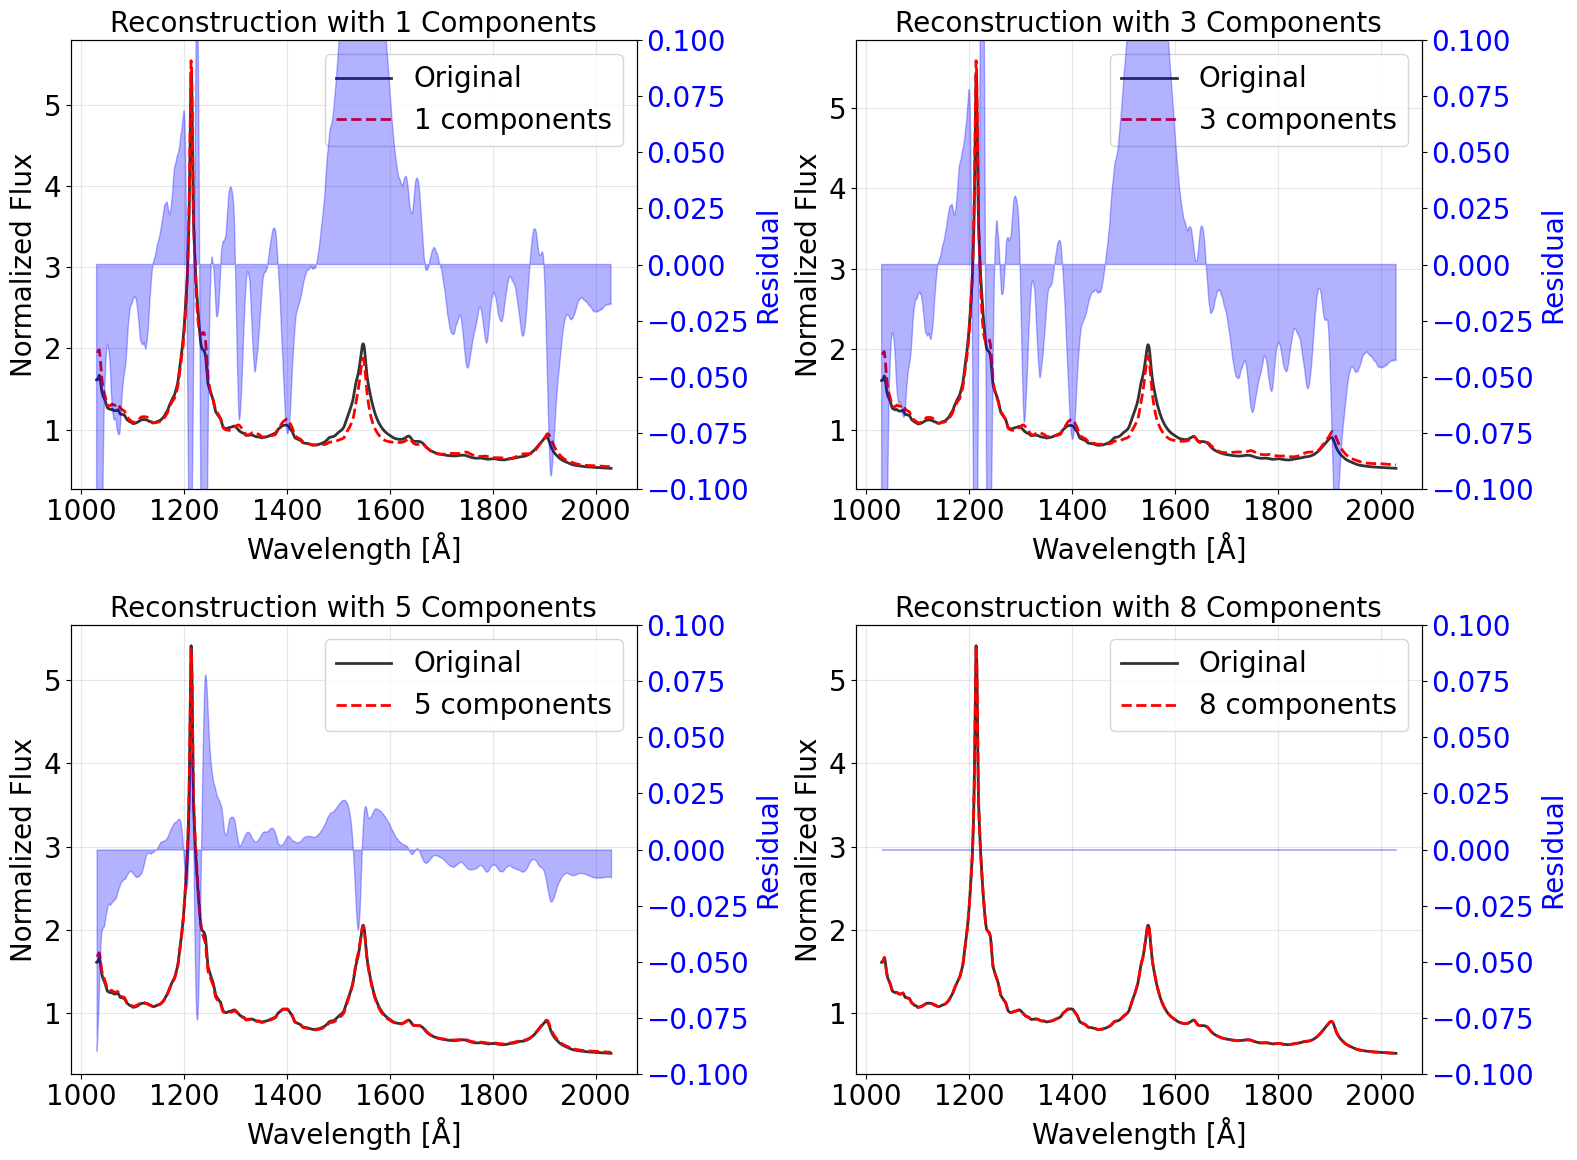

In [48]:
# Plot original spectrum and reconstructions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, n_comp in enumerate(n_components_list):
    ax = axes[i]
    
    # Plot original and reconstruction
    ax.plot(wavelength, test_spectrum, 'k-', linewidth=2, 
            label='Original', alpha=0.8)
    ax.plot(wavelength, reconstructions[n_comp], 'r--', linewidth=2,
            label=f'{n_comp} components')
    
    # Add residual plot in the background
    residual = test_spectrum - reconstructions[n_comp]
    ax_twin = ax.twinx()
    ax_twin.fill_between(wavelength, residual, alpha=0.3, color='blue')
    ax_twin.set_ylabel('Residual', color='blue')
    ax_twin.tick_params(axis='y', labelcolor='blue')
    ax_twin.set_ylim(-0.1, 0.1)
    
    # Get variance explained for this number of components
    var_explained = cumulative_variance_ratio[n_comp-1] * 100
    
    # Formatting
    ax.set_xlabel('Wavelength [Å]')
    ax.set_ylabel('Normalized Flux')
    ax.set_title(f'Reconstruction with {n_comp} Components')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The reconstruction analysis demonstrates the remarkable effectiveness of PCA compression on these simulated spectra. Even with just a single component, the basic continuum shape is captured, preserving the overall spectral energy distribution. By the time we use 3 components (capturing 90% of variance), the reconstruction is nearly indistinguishable from the original, with residuals at the level of a few percent. With 8 components (99.9% variance), the reconstruction is essentially perfect.

The residuals (shown in blue) reveal what information is lost at each compression level. With very few components, we miss some of the detailed structure in emission lines and continuum curvature. As we add components, these features are progressively recovered. This hierarchical reconstruction reflects how PCA orders information by importance—the most significant spectral features are encoded in the first few components.

The extreme efficiency of compression—achieving near-perfect reconstruction with just 8 out of 2,947 dimensions—confirms that these simulated spectra were generated from a low-dimensional model. Real observational data would likely require more components due to additional sources of variation like instrumental effects, atmospheric contamination, and the full complexity of astrophysical processes. Nevertheless, this analysis demonstrates the fundamental principle that astronomical spectra, despite their high-dimensional representation, often lie on much lower-dimensional manifolds determined by the underlying physics.

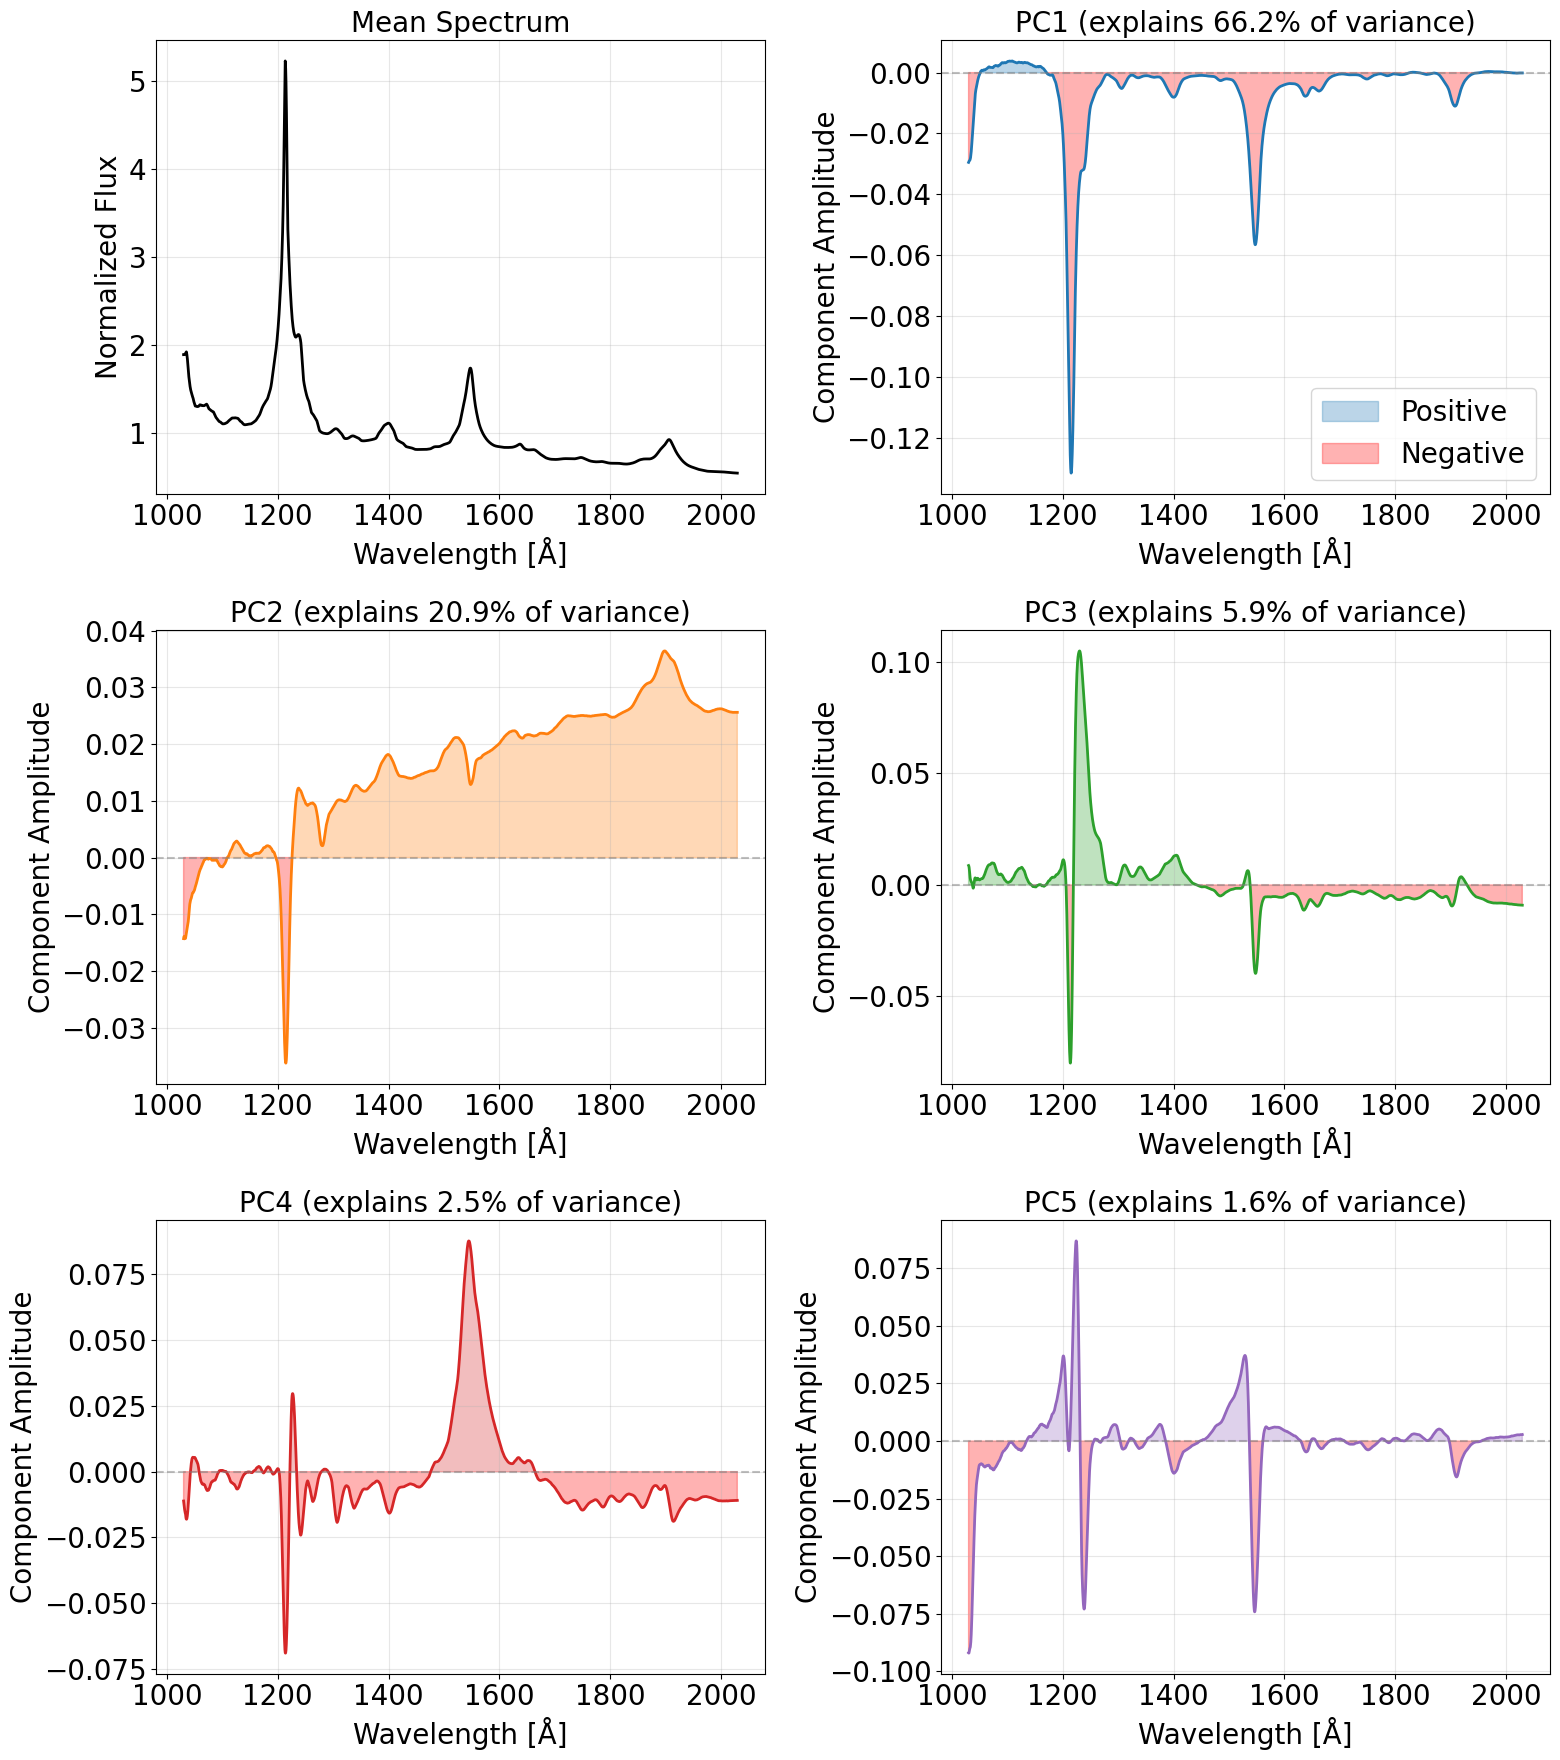

In [49]:
# Plot the first few principal components and the mean spectrum
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Plot the mean spectrum
ax = axes[0, 0]
ax.plot(wavelength, X_mean, 'k-', linewidth=2)
ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel('Normalized Flux')
ax.set_title('Mean Spectrum')
ax.grid(True, alpha=0.3)

# Plot the first 5 principal components
for i in range(5):
    ax = axes[(i+1)//2, (i+1)%2]
    
    # Plot the component
    ax.plot(wavelength, components[i], linewidth=2, color=f'C{i}')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Add shading to show positive/negative regions
    ax.fill_between(wavelength, components[i], where=(components[i] > 0), 
                    alpha=0.3, color=f'C{i}', label='Positive')
    ax.fill_between(wavelength, components[i], where=(components[i] < 0), 
                    alpha=0.3, color='red', label='Negative')
    
    # Formatting
    ax.set_xlabel('Wavelength [Å]')
    ax.set_ylabel('Component Amplitude')
    ax.set_title(f'PC{i+1} (explains {explained_variance_ratio[i]*100:.1f}% of variance)')
    ax.grid(True, alpha=0.3)
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

### Interpreting the Principal Component Structure

The principal components reveal a clear hierarchy of spectral variations in our quasar dataset:

**Mean Spectrum**: Shows the average quasar continuum with prominent Lyα (1215 Å) and C IV (1549 Å) emission lines, plus additional features. The continuum follows the expected power-law shape characteristic of multi-temperature blackbody emission from the accretion disk.

**PC1**: Dominated by strong negative features at all emission lines, particularly Lyα and C IV. This component captures the primary mode of variation—differences in overall emission line strength relative to the continuum. Quasars with positive PC1 coefficients have weaker emission lines, while those with negative coefficients have stronger lines. This likely reflects variations in the covering factor or ionization state of the broad-line region.

**PC2**: Represents variations in the power-law slope of the continuum. The tilted shape that rises toward longer wavelengths captures differences in the spectral index α. This variation in power-law slope could arise from differences in accretion rate, black hole mass, or viewing angle—all of which affect the temperature distribution in the accretion disk. Bluer quasars (steeper power laws) would have negative PC2 coefficients, while redder quasars would have positive coefficients.

**PC3**: Features a dramatic positive peak at Lyα contrasted with a negative feature at C IV. This component encodes the relative strength of Lyα versus metal lines, potentially reflecting variations in metallicity or differences in the ionization structure of the broad-line region.

**PC4**: Shows the opposite pattern to PC3—strong positive C IV feature with negative Lyα contribution. Together, PC3 and PC4 form a pair that allows the model to adjust the relative strengths of different emission lines independently, capturing the diversity in line ratios observed across the quasar population.

**PC5**: Contains multiple narrow positive and negative features across the spectrum, capturing finer details in the spectral shape and secondary emission line variations. These higher-order components progressively encode more subtle spectral features.

This component structure reflects the physical processes governing quasar emission: the dominant variations involve emission line strength and continuum shape, with progressively finer details captured by higher-order components.

## Clustering in PCA Space

Having successfully compressed our quasar spectra from thousands of dimensions to just a handful of principal components, we now face a new opportunity. With each quasar represented by only 8 numbers, we can efficiently explore the distribution of quasars in this reduced parameter space and identify potential subpopulations.

The combination of dimensionality reduction and clustering provides a powerful framework for understanding complex astronomical datasets. By first reducing the dimensionality with PCA, we avoid the curse of dimensionality that plagues clustering algorithms in high-dimensional spaces. The principal components also ensure that our clustering focuses on the most significant variations in the data, rather than being distracted by noise or minor features.

First, let's transform our full dataset into PCA space using the 8 principal components that capture essentially all the variance:

In [50]:
# Choose number of components based on our variance analysis
n_components_pca = 8  # Captures 99.9% of variance

# Project all spectra onto the principal components
X_centered = X - X_mean
X_pca = X_centered @ components[:n_components_pca].T

print(f"Original data shape: {X.shape}")
print(f"PCA-transformed data shape: {X_pca.shape}")
print(f"Compression ratio: {X.shape[1] / n_components_pca:.1f}×")

# Calculate some statistics in PCA space
print(f"\nPCA coefficient statistics:")
for i in range(min(4, n_components_pca)):
    print(f"  PC{i+1}: mean = {np.mean(X_pca[:, i]):.3f}, std = {np.std(X_pca[:, i]):.3f}")

Original data shape: (1000, 2947)
PCA-transformed data shape: (1000, 8)
Compression ratio: 368.4×

PCA coefficient statistics:
  PC1: mean = 0.000, std = 8.436
  PC2: mean = 0.000, std = 4.744
  PC3: mean = 0.000, std = 2.523
  PC4: mean = 0.000, std = 1.631


Before applying clustering algorithms, let's examine how quasars are distributed in the principal component space. This visualization will help us understand whether distinct groups exist and guide our choice of clustering parameters:


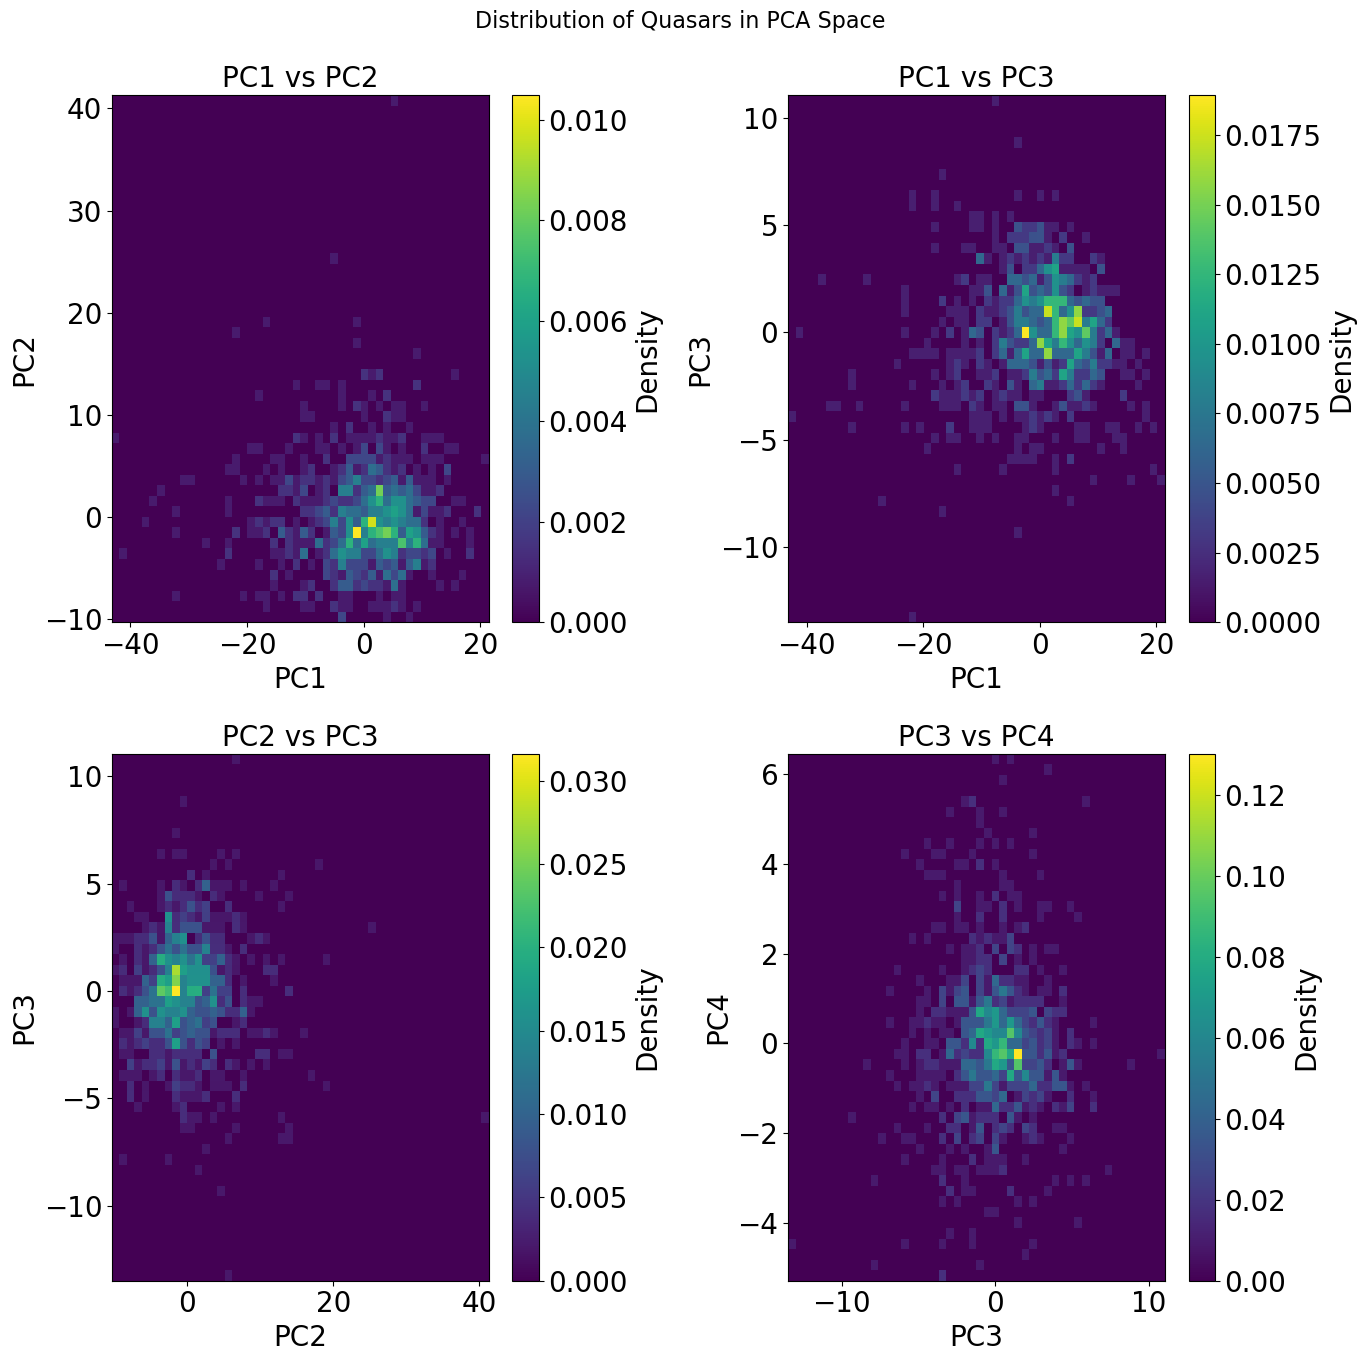

In [51]:
# Visualize the distribution in the first few PC dimensions
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Plot 2D projections of the first 4 components
pc_pairs = [(0, 1), (0, 2), (1, 2), (2, 3)]
pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']

for ax, (pc1, pc2) in zip(axes.ravel(), pc_pairs):
    # Create 2D histogram
    hist = ax.hist2d(X_pca[:, pc1], X_pca[:, pc2], 
                     bins=50, cmap='viridis', density=True)
    plt.colorbar(hist[3], ax=ax, label='Density')
    
    ax.set_xlabel(pc_labels[pc1])
    ax.set_ylabel(pc_labels[pc2])
    ax.set_title(f'{pc_labels[pc1]} vs {pc_labels[pc2]}')

plt.suptitle('Distribution of Quasars in PCA Space', fontsize=16)
plt.tight_layout()
plt.show()


## Gaussian Mixture Models in PCA Space

Having compressed our quasar spectra to just 8 dimensions, we can now efficiently model the distribution of quasars in this reduced parameter space. Gaussian Mixture Models (GMM) provide a probabilistic framework that goes beyond simple clustering—they allow us to:

- Model complex, multi-modal distributions
- Generate realistic synthetic spectra for testing analysis pipelines
- Detect outliers through likelihood-based methods
- Quantify uncertainty in cluster assignments

### Mathematical Framework

A Gaussian Mixture Model represents the distribution of our PCA-transformed quasar data as a weighted sum of multivariate Gaussian distributions:

$$p(\mathbf{z}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{z}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$$

where:
- $\pi_k$ represents the mixing weight of component $k$ (with $\sum_{k=1}^K \pi_k = 1$)
- $\boldsymbol{\mu}_k$ is the mean vector of component $k$ in 8D PCA space
- $\boldsymbol{\Sigma}_k$ is the 8×8 covariance matrix of component $k$
- $\mathcal{N}(\mathbf{z}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ denotes the multivariate Gaussian distribution

Each Gaussian component can be interpreted as representing a distinct "type" of quasar, characterized by its typical location in PCA space (the mean) and the spread and correlations of its member spectra (the covariance).

### Implementing Gaussian Mixture Models

Let's implement GMM from scratch using the Expectation-Maximization (EM) algorithm. First, we'll split our data into training and testing sets:


In [52]:
# Split data into training and testing sets
train_size = int(0.8 * len(X_pca))
indices = np.random.permutation(len(X_pca))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train = X_pca[train_indices]
X_test = X_pca[test_indices]

print(f"Training set size: {X_train.shape[0]} spectra")
print(f"Testing set size: {X_test.shape[0]} spectra")
print(f"Dimensionality: {X_train.shape[1]} PCA components")

Training set size: 800 spectra
Testing set size: 200 spectra
Dimensionality: 8 PCA components


### The Multivariate Gaussian Distribution

The foundation of GMM is the multivariate Gaussian probability density function. For a d-dimensional random vector $\mathbf{z}$, the PDF is:

$$\mathcal{N}(\mathbf{z}|\boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{d/2}|\boldsymbol{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{z}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\mathbf{z}-\boldsymbol{\mu})\right)$$

where $|\boldsymbol{\Sigma}|$ denotes the determinant of the covariance matrix. Let's implement this function:


In [53]:
def multivariate_gaussian_pdf(X, mu, sigma):
    """
    Compute the PDF of a multivariate Gaussian distribution
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The data points
    mu : array, shape (n_features,)
        The mean vector
    sigma : array, shape (n_features, n_features)
        The covariance matrix
    
    Returns:
    --------
    pdf_values : array, shape (n_samples,)
        The PDF values for each data point
    """
    n_features = X.shape[1]
    
    # Add small regularization to ensure numerical stability
    sigma_reg = sigma + np.eye(n_features) * 1e-6
    
    # Compute the normalization constant
    det_sigma = np.linalg.det(sigma_reg)
    norm_const = 1.0 / np.sqrt((2 * np.pi) ** n_features * det_sigma)
    
    # Compute the inverse of the covariance matrix
    inv_sigma = np.linalg.inv(sigma_reg)
    
    # Compute PDF for each data point
    n_samples = X.shape[0]
    pdf_values = np.zeros(n_samples)
    
    for i in range(n_samples):
        diff = X[i] - mu
        exponent = -0.5 * diff @ inv_sigma @ diff
        pdf_values[i] = norm_const * np.exp(exponent)
    
    return pdf_values


Proper initialization is crucial for GMM convergence. We'll use a simple strategy that spreads the initial Gaussian components across the data space:

In [54]:

def initialize_gmm(X, k, random_state=None):
    """
    Initialize GMM parameters
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of components
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    weights : array, shape (k,)
        Initial mixture weights
    means : array, shape (k, n_features)
        Initial component means
    covariances : array, shape (k, n_features, n_features)
        Initial component covariances
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples, n_features = X.shape
    
    # Initialize weights uniformly
    weights = np.ones(k) / k
    
    # Initialize means by randomly selecting k data points
    indices = np.random.choice(n_samples, k, replace=False)
    means = X[indices].copy()
    
    # Initialize covariances as scaled identity matrices
    # Use the variance of the data to set the scale
    data_variance = np.var(X, axis=0).mean()
    covariances = np.array([np.eye(n_features) * data_variance for _ in range(k)])
    
    return weights, means, covariances


### The E-step: Computing Responsibilities

In the Expectation step of GMM, we compute the posterior probability that each data point belongs to each Gaussian component. These "responsibilities" quantify the likelihood that quasar $n$ originated from component $k$:

$$\gamma_{nk} = \frac{\pi_k \mathcal{N}(\mathbf{z}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{z}_n|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}$$

The numerator represents the weighted probability density of observing quasar $n$ from component $k$, while the denominator ensures the responsibilities sum to 1 across all components for each quasar.

This soft assignment fundamentally differs from hard clustering approaches. A quasar positioned between two components might have responsibilities of 0.6 and 0.4, reflecting genuine uncertainty about its classification. This probabilistic framework naturally handles overlapping populations and provides uncertainty quantification.

During the E-step, we also compute the log-likelihood of observing our data given the current model parameters:

$$\log \mathcal{L} = \sum_{n=1}^N \log \left( \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{z}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \right)$$

This quantity serves as our objective function and convergence metric.

In [55]:
def e_step(X, weights, means, covariances):
    """
    E-step: Compute responsibilities (posterior probabilities)
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    weights : array, shape (k,)
        Mixture weights
    means : array, shape (k, n_features)
        Component means
    covariances : array, shape (k, n_features, n_features)
        Component covariances
    
    Returns:
    --------
    responsibilities : array, shape (n_samples, k)
        Responsibility of each component for each sample
    log_likelihood : float
        Log-likelihood of the data under the current model
    """
    n_samples = X.shape[0]
    k = len(weights)
    
    # Compute weighted probabilities for each component
    weighted_probs = np.zeros((n_samples, k))
    
    for i in range(k):
        # Compute probability density for component i
        prob_density = multivariate_gaussian_pdf(X, means[i], covariances[i])
        # Weight by mixture coefficient
        weighted_probs[:, i] = weights[i] * prob_density
    
    # Total probability for each data point (marginal likelihood)
    total_probs = np.sum(weighted_probs, axis=1)
    
    # Avoid numerical issues with log(0)
    total_probs = np.maximum(total_probs, 1e-300)
    
    # Compute responsibilities (normalize to sum to 1)
    responsibilities = weighted_probs / total_probs.reshape(-1, 1)
    
    # Compute log-likelihood
    log_likelihood = np.sum(np.log(total_probs))
    
    return responsibilities, log_likelihood

### The M-step: Updating Model Parameters

Given the responsibilities computed in the E-step, the Maximization step updates the model parameters to maximize the expected log-likelihood. The update equations elegantly generalize the concept of weighted averages, with each quasar contributing to parameter estimates proportionally to its responsibility.

First, we define the effective number of quasars in each component:
$$N_k = \sum_{n=1}^N \gamma_{nk}$$

This "soft count" replaces the hard count used in simpler clustering methods, allowing quasars to partially contribute to multiple components. The parameter updates then follow:

**Mixture weights**: The fraction of the total population in each component
$$\pi_k^{new} = \frac{N_k}{N}$$

**Means**: The responsibility-weighted average position
$$\boldsymbol{\mu}_k^{new} = \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk} \mathbf{z}_n$$

**Covariances**: The responsibility-weighted scatter around the mean
$$\boldsymbol{\Sigma}_k^{new} = \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk} (\mathbf{z}_n - \boldsymbol{\mu}_k^{new})(\mathbf{z}_n - \boldsymbol{\mu}_k^{new})^T$$

These updates have intuitive interpretations. Quasars with high responsibility for a component strongly influence its parameters, while those with low responsibility contribute minimally. This creates a self-reinforcing process: components adjust to better fit their most probable members, which in turn refines the responsibility assignments.

In [56]:
def m_step(X, responsibilities):
    """
    M-step: Update parameters based on responsibilities
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    responsibilities : array, shape (n_samples, k)
        Responsibility of each component for each sample
    
    Returns:
    --------
    weights : array, shape (k,)
        Updated mixture weights
    means : array, shape (k, n_features)
        Updated component means
    covariances : array, shape (k, n_features, n_features)
        Updated component covariances
    """
    n_samples, n_features = X.shape
    k = responsibilities.shape[1]
    
    # Compute effective number of points per component
    N_k = np.sum(responsibilities, axis=0)
    
    # Update mixture weights
    weights = N_k / n_samples
    
    # Initialize parameters
    means = np.zeros((k, n_features))
    covariances = np.zeros((k, n_features, n_features))
    
    # Update means and covariances for each component
    for i in range(k):
        # Update mean: weighted average of data points
        for n in range(n_samples):
            means[i] += responsibilities[n, i] * X[n]
        means[i] /= N_k[i]
        
        # Update covariance: weighted outer products
        cov_sum = np.zeros((n_features, n_features))
        for n in range(n_samples):
            diff = X[n] - means[i]
            cov_sum += responsibilities[n, i] * np.outer(diff, diff)
        
        covariances[i] = cov_sum / N_k[i]
        
        # Add regularization for numerical stability
        covariances[i] += np.eye(n_features) * 1e-6
    
    return weights, means, covariances

### The Complete EM Algorithm for GMM

We now combine the E-step and M-step into the complete Expectation-Maximization algorithm for Gaussian Mixture Models. The EM algorithm provides an elegant solution to a challenging optimization problem: maximizing the likelihood of a mixture model where both the parameters and the component assignments are unknown.

The algorithm proceeds iteratively:
1. **Initialize** parameters (weights, means, covariances)
2. **E-step**: Compute responsibilities given current parameters
3. **M-step**: Update parameters given current responsibilities
4. **Repeat** until the log-likelihood converges

A key theoretical guarantee of EM is that the log-likelihood never decreases—each iteration either improves the fit or maintains it. This monotonic improvement ensures convergence to a local maximum, though not necessarily the global optimum (hence the importance of good initialization).

We monitor convergence by tracking the change in log-likelihood between iterations, stopping when this change falls below a threshold.

In [57]:
def fit_gmm(X, k, max_iter=100, tol=1e-4, random_state=None):
    """
    Fit a Gaussian Mixture Model using the EM algorithm
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of components
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance (change in log-likelihood)
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    weights : array, shape (k,)
        Final mixture weights
    means : array, shape (k, n_features)
        Final component means
    covariances : array, shape (k, n_features, n_features)
        Final component covariances
    responsibilities : array, shape (n_samples, k)
        Final responsibilities
    log_likelihood : float
        Final log-likelihood
    n_iter : int
        Number of iterations run
    history : dict
        Dictionary containing convergence history
    """
    # Initialize parameters
    weights, means, covariances = initialize_gmm(X, k, random_state)
    
    # Initialize history tracking
    history = {
        'log_likelihood': [],
        'weights': [weights.copy()],
        'means': [means.copy()],
        'covariances': [covariances.copy()]
    }
    
    # Initialize log-likelihood
    old_log_likelihood = -np.inf
    
    # EM iterations
    for iteration in range(max_iter):
        # E-step
        responsibilities, log_likelihood = e_step(X, weights, means, covariances)
        history['log_likelihood'].append(log_likelihood)
        
        # Check convergence
        log_likelihood_change = log_likelihood - old_log_likelihood
        if log_likelihood_change < tol:
            break
        
        old_log_likelihood = log_likelihood
        
        # M-step
        weights, means, covariances = m_step(X, responsibilities)
        
        # Store updated parameters
        history['weights'].append(weights.copy())
        history['means'].append(means.copy())
        history['covariances'].append(covariances.copy())
    
    # Final E-step for responsibilities
    responsibilities, log_likelihood = e_step(X, weights, means, covariances)
    
    return weights, means, covariances, responsibilities, log_likelihood, iteration + 1, history

### Model Selection with Bayesian Information Criterion

A fundamental challenge in mixture modeling is determining the appropriate number of components. Too few components may fail to capture important structure in the data, while too many can lead to overfitting. The Bayesian Information Criterion (BIC) provides a principled approach to this model selection problem.

BIC balances goodness-of-fit against model complexity:

$$\text{BIC} = -2\ln(\hat{L}) + P\ln(N)$$

where $\hat{L}$ is the maximized likelihood, $P$ is the number of parameters, and $N$ is the sample size. Lower BIC values indicate better models.

The BIC's penalty term $P\ln(N)$ grows with sample size, making it conservative about adding complexity. This property aligns well with our goal of building a robust generative model that captures the essential structure of quasar diversity without overfitting to training set peculiarities.

For a $K$-component GMM in $D$ dimensions with full covariance matrices, the parameter count is:
- Mixture weights: $K-1$ (constrained to sum to 1)  
- Means: $K \times D$
- Covariances: $K \times D(D+1)/2$ (symmetric matrices)

In our 8D case: $P = (K-1) + 8K + 36K = 45K - 1$

Let's fit GMMs with different numbers of components and use BIC to select the optimal model:

In [58]:
# Test different numbers of Gaussian components
n_components_range = range(1, 6) 
n_init = 10  # Number of random initializations for each model

bic_scores = []
log_likelihoods = []
best_models = {}

print("Fitting GMMs with different numbers of components...")
print("(Using best of 10 random initializations for each K)")

for n_components in n_components_range:
    # Try multiple initializations and keep the best
    best_log_likelihood = -np.inf
    best_params = None
    
    for init in range(n_init):
        # Fit GMM with different random seed
        weights, means, covariances, responsibilities, log_likelihood, n_iter, history = fit_gmm(
            X_train, n_components, random_state=42 + init)
        
        # Keep track of best model
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_params = (weights, means, covariances, responsibilities, history)
    
    # Store best model
    best_models[n_components] = best_params
    
    # Calculate BIC for best model
    n_features = X_train.shape[1]
    n_samples = X_train.shape[0]
    n_params = (n_components - 1) + n_components * n_features + \
               n_components * n_features * (n_features + 1) // 2
    
    bic = -2 * best_log_likelihood + n_params * np.log(n_samples)
    
    bic_scores.append(bic)
    log_likelihoods.append(best_log_likelihood)
    
    print(f"  K={n_components}: Best log-likelihood = {best_log_likelihood:.2f}, "
          f"BIC = {bic:.2f}, Parameters = {n_params}")

Fitting GMMs with different numbers of components...
(Using best of 10 random initializations for each K)
  K=1: Best log-likelihood = -13506.99, BIC = 27308.10, Parameters = 44
  K=2: Best log-likelihood = -12864.69, BIC = 26324.31, Parameters = 89
  K=3: Best log-likelihood = -12679.64, BIC = 26255.01, Parameters = 134
  K=4: Best log-likelihood = -12579.29, BIC = 26355.13, Parameters = 179
  K=5: Best log-likelihood = -12486.54, BIC = 26470.43, Parameters = 224


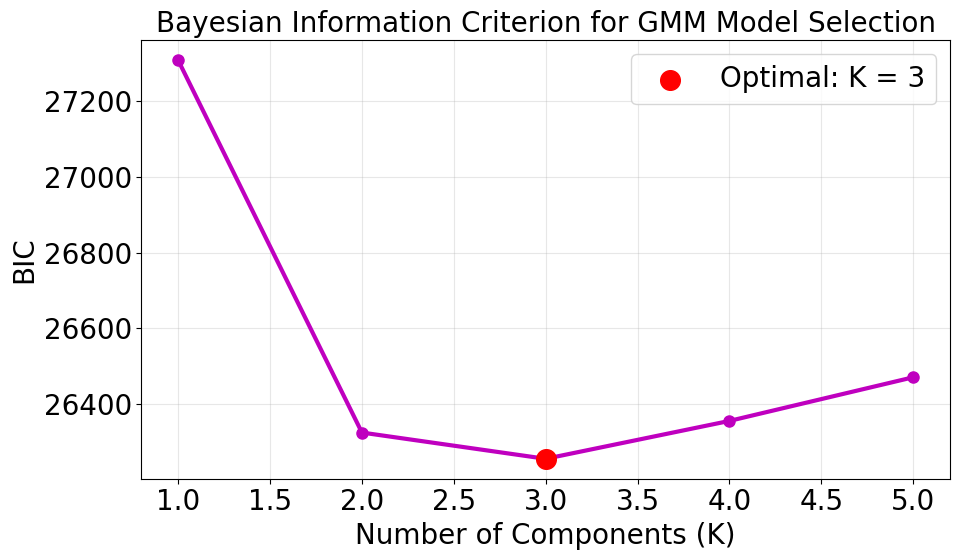


BIC selects K = 3 components as optimal
BIC improvement from K=3 to K=4: 100.1


In [60]:
# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, 'm-', linewidth=3, 
         marker='o', markersize=8)

# Mark the minimum
bic_min_idx = np.argmin(bic_scores)
optimal_components = n_components_range[bic_min_idx]
plt.scatter(optimal_components, bic_scores[bic_min_idx], 
            color='red', s=200, zorder=5,
            label=f'Optimal: K = {optimal_components}')

plt.xlabel('Number of Components (K)')
plt.ylabel('BIC')
plt.title('Bayesian Information Criterion for GMM Model Selection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBIC selects K = {optimal_components} components as optimal")
print(f"BIC improvement from K={optimal_components} to K={optimal_components+1}: "
      f"{bic_scores[optimal_components] - bic_scores[optimal_components-1]:.1f}")

The BIC analysis clearly identifies K=3 as the optimal number of components, with BIC values increasing sharply for K>4. This suggests that our quasar population in PCA space can be well-described by three Gaussian components. The fact that adding more components leads to worse BIC scores indicates they would be modeling noise or overfitting rather than capturing meaningful structure.

The three-component model strikes a balance between complexity and parsimony. With just three Gaussians in 8-dimensional PCA space, we can characterize the diversity of quasar spectra in our sample. 

Let's fit our final model and visualize how these three components partition the quasar population:

In [61]:
# Fit the final GMM with BIC-optimal number of components
optimal_k = 3
print(f"Fitting final GMM with K={optimal_k} components...")

# Use the best model from our search
weights_final, means_final, covariances_final, responsibilities_final, _ = best_models[optimal_k]

# Evaluate on test set
responsibilities_test, log_likelihood_test = e_step(X_test, weights_final, 
                                                   means_final, covariances_final)

print(f"\nFinal GMM with {optimal_k} components:")
print(f"Component weights: {weights_final}")
print(f"Test set log-likelihood: {log_likelihood_test:.2f}")

# Assign each point to its most likely component
component_assignments_train = np.argmax(responsibilities_final, axis=1)
component_assignments_test = np.argmax(responsibilities_test, axis=1)

# Report component sizes
print("\nComponent sizes in training set:")
for i in range(optimal_k):
    n_points = np.sum(component_assignments_train == i)
    print(f"  Component {i}: {n_points} quasars ({n_points/len(X_train)*100:.1f}%)")

Fitting final GMM with K=3 components...

Final GMM with 3 components:
Component weights: [0.36136672 0.1925476  0.44608568]
Test set log-likelihood: -3105.46

Component sizes in training set:
  Component 0: 289 quasars (36.1%)
  Component 1: 139 quasars (17.4%)
  Component 2: 372 quasars (46.5%)


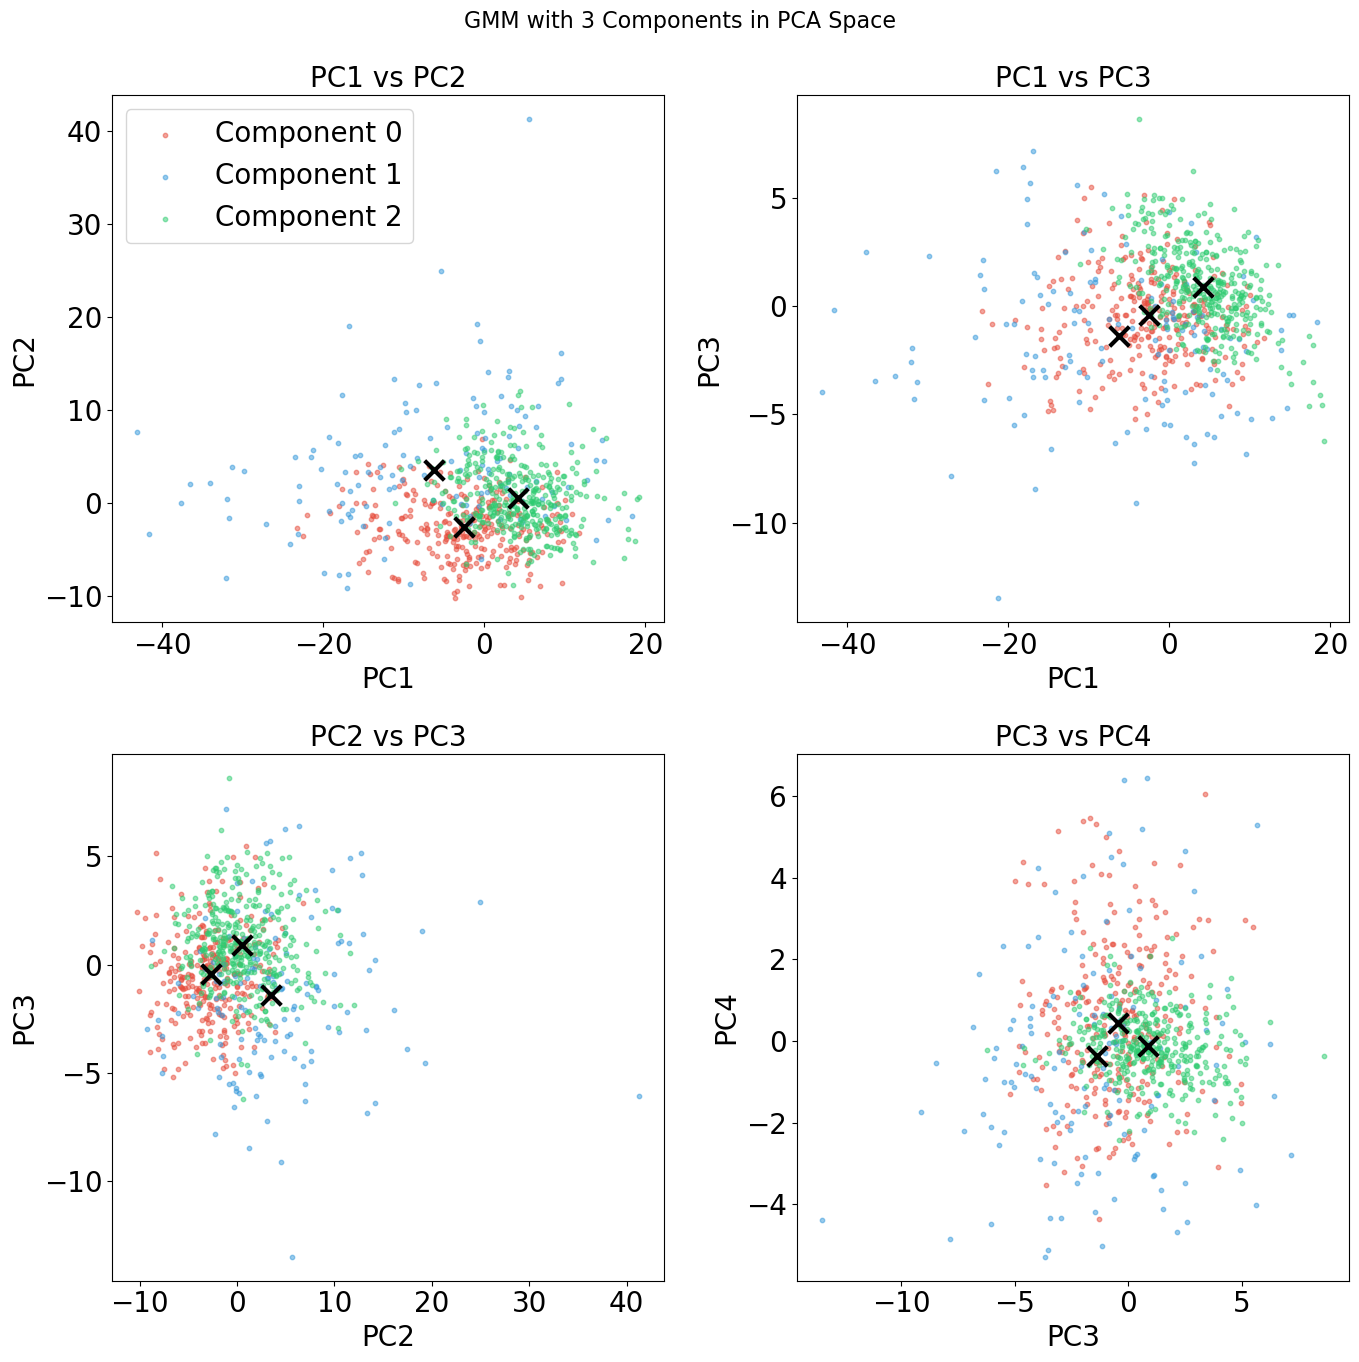

In [62]:
# Visualize the 3-component GMM in PCA space
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Plot 2D projections
pc_pairs = [(0, 1), (0, 2), (1, 2), (2, 3)]
pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
colors = ['#e74c3c', '#3498db', '#2ecc71']  # Red, Blue, Green

for ax_idx, (pc1, pc2) in enumerate(pc_pairs):
    ax = axes.ravel()[ax_idx]
    
    # Plot points colored by component assignment
    for i in range(optimal_k):
        mask = component_assignments_train == i
        ax.scatter(X_train[mask, pc1], X_train[mask, pc2], 
                  c=colors[i], s=10, alpha=0.5, label=f'Component {i}')
    
    # Plot component means
    for i in range(optimal_k):
        ax.scatter(means_final[i, pc1], means_final[i, pc2], 
                  c='black', s=200, marker='x', linewidth=3)
    
    # Add labels
    ax.set_xlabel(pc_labels[pc1])
    ax.set_ylabel(pc_labels[pc2])
    ax.set_title(f'{pc_labels[pc1]} vs {pc_labels[pc2]}')
    if ax_idx == 0:
        ax.legend()

plt.suptitle(f'GMM with {optimal_k} Components in PCA Space', fontsize=16)
plt.tight_layout()
plt.show()

The visualization shows how the three GMM components partition the quasar population in PCA space. The components (shown in red, blue, and green) overlap significantly rather than forming distinct clusters, reflecting the continuous nature of quasar spectral variation. The black crosses mark the component centers, which are positioned to cover different regions of the parameter space while maintaining substantial overlap.

This overlap is a key feature of GMM—unlike hard clustering methods, it acknowledges that quasars near component boundaries could plausibly belong to multiple groups. The probabilistic assignments provide a more nuanced description than forcing each spectrum into a single category.

## Generating Synthetic Quasar Spectra

With our trained GMM operating in 8-dimensional PCA space, we can now generate synthetic quasar spectra. This capability has several important applications:

- Creating mock datasets for testing spectroscopic analysis pipelines
- Augmenting limited observational samples for machine learning applications
- Understanding the range of spectral diversity captured by our model
- Validating that our dimensionality reduction preserves essential spectral features

### Mathematical Framework

Generating synthetic spectra from our model follows a hierarchical process that reverses the analysis pipeline. We first sample from the GMM in PCA space, then transform back to the full spectral space.

The sampling process from a K-component GMM proceeds in two stages:

1. **Sample component assignment**: Draw a component index $k$ from the categorical distribution defined by the mixture weights:
   $$k \sim \text{Categorical}(\pi_1, \pi_2, \pi_3)$$

2. **Sample from the selected component**: Given component $k$, draw a sample from its multivariate Gaussian distribution:
   $$\mathbf{z} \sim \mathcal{N}(\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$$

This gives us a new point $\mathbf{z} \in \mathbb{R}^8$ in PCA space. To generate the full spectrum, we apply the inverse PCA transformation:

$$\mathbf{x} = \mathbf{z}\mathbf{V}^T + \bar{\mathbf{x}}$$

where $\mathbf{V} \in \mathbb{R}^{8 \times 2947}$ contains the first 8 principal components (as rows) and $\bar{\mathbf{x}}$ is the mean spectrum. This reconstruction projects our 8D point back to the full 2,947-dimensional spectral space.

This approach ensures that synthetic spectra respect all the correlations learned by our model—the GMM captures the distribution in reduced space while the PCA components maintain the relationships between wavelength bins.

In [64]:
def sample_from_gmm(weights, means, covariances, n_samples):
    """
    Sample from a Gaussian Mixture Model
    
    Parameters:
    -----------
    weights : array, shape (k,)
        Mixture weights
    means : array, shape (k, n_features)
        Component means
    covariances : array, shape (k, n_features, n_features)
        Component covariances
    n_samples : int
        Number of samples to generate
    
    Returns:
    --------
    samples : array, shape (n_samples, n_features)
        Generated samples
    component_labels : array, shape (n_samples,)
        Component assignment for each sample
    """
    k = len(weights)
    n_features = means.shape[1]
    
    # Sample component assignments
    component_labels = np.random.choice(k, size=n_samples, p=weights)
    
    # Sample from each component
    samples = np.zeros((n_samples, n_features))
    for i in range(n_samples):
        comp = component_labels[i]
        samples[i] = np.random.multivariate_normal(means[comp], covariances[comp])
    
    return samples, component_labels

# Generate synthetic quasar spectra
n_synthetic = 1000
print(f"Generating {n_synthetic} synthetic quasar spectra...")

# Sample from the GMM in PCA space
synthetic_pca, component_labels = sample_from_gmm(weights_final, means_final, 
                                                  covariances_final, n_synthetic)
print(f"Sampled points shape in PCA space: {synthetic_pca.shape}")

# Reconstruct full spectra from PCA coefficients
synthetic_spectra = synthetic_pca @ components[:n_components_pca] + X_mean

print(f"Reconstructed spectra shape: {synthetic_spectra.shape}")

Generating 1000 synthetic quasar spectra...
Sampled points shape in PCA space: (1000, 8)
Reconstructed spectra shape: (1000, 2947)


### Validating Generation

To assess the quality of our synthetic spectra, we need to verify that they match the statistical properties of the original data. A comprehensive validation should examine both the overall distribution of flux values across wavelengths and the diversity of individual spectral shapes.

Let's compare the pixel-wise statistics between real and synthetic spectra:

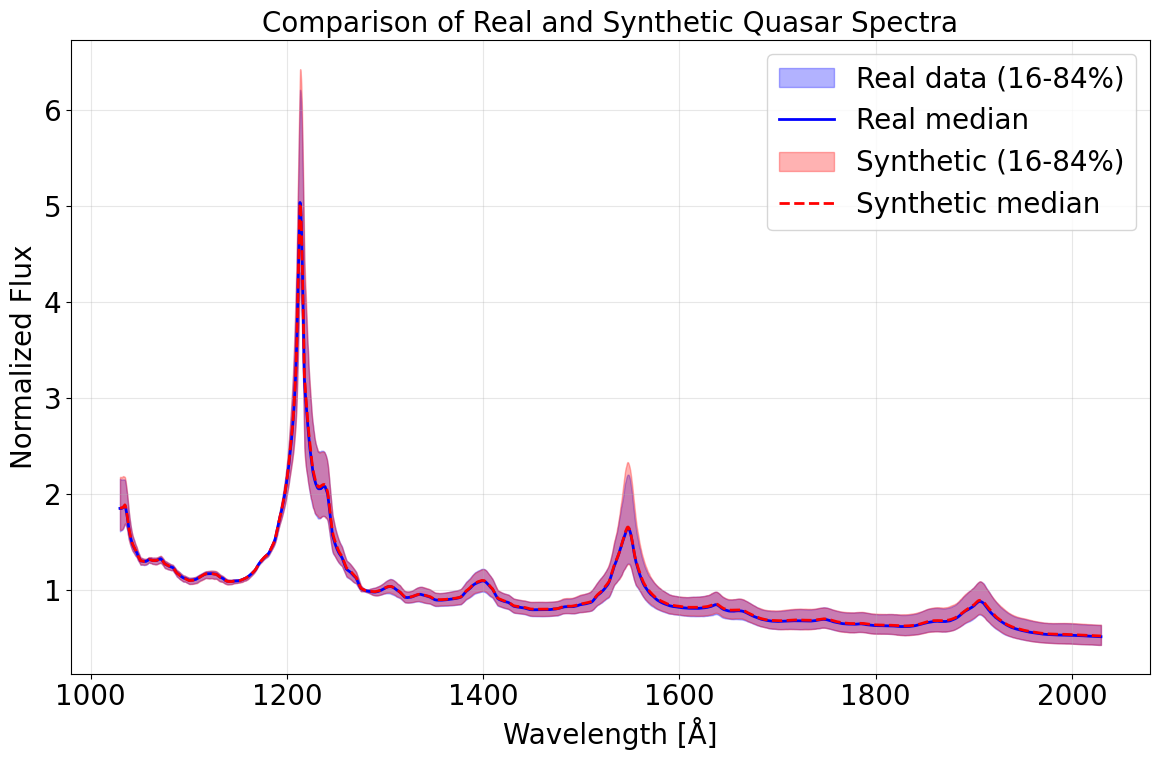

In [65]:
# Calculate pixel-wise statistics
percentiles = [16, 50, 84]  # 1-sigma range

# Real data statistics (using training set)
real_percentiles = np.percentile(X[train_indices], percentiles, axis=0)
real_median = real_percentiles[1]
real_lower = real_percentiles[0]
real_upper = real_percentiles[2]

# Synthetic data statistics
synthetic_percentiles = np.percentile(synthetic_spectra, percentiles, axis=0)
synthetic_median = synthetic_percentiles[1]
synthetic_lower = synthetic_percentiles[0]
synthetic_upper = synthetic_percentiles[2]

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Plot median and 1-sigma ranges
ax.fill_between(wavelength, real_lower, real_upper, 
                alpha=0.3, color='blue', label='Real data (16-84%)')
ax.plot(wavelength, real_median, 'b-', linewidth=2, label='Real median')

ax.fill_between(wavelength, synthetic_lower, synthetic_upper, 
                alpha=0.3, color='red', label='Synthetic (16-84%)')
ax.plot(wavelength, synthetic_median, 'r--', linewidth=2, label='Synthetic median')

ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel('Normalized Flux')
ax.set_title('Comparison of Real and Synthetic Quasar Spectra')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The comparison shows excellent agreement between real and synthetic spectra. The median spectra overlap almost perfectly across all wavelengths, and the 1-sigma ranges (16th to 84th percentiles) match closely. This confirms that our GMM successfully captures the statistical distribution of quasar spectra.

The synthetic spectra preserve key features:
- The prominent Lyα emission line at 1215 Å with appropriate strength variations
- The C IV line at 1549 Å and other emission features
- Realistic continuum shapes with proper power-law slopes
- Appropriate levels of spectral diversity as shown by the width of the 1-sigma bands

Let's examine a few individual synthetic spectra to verify they look realistic:


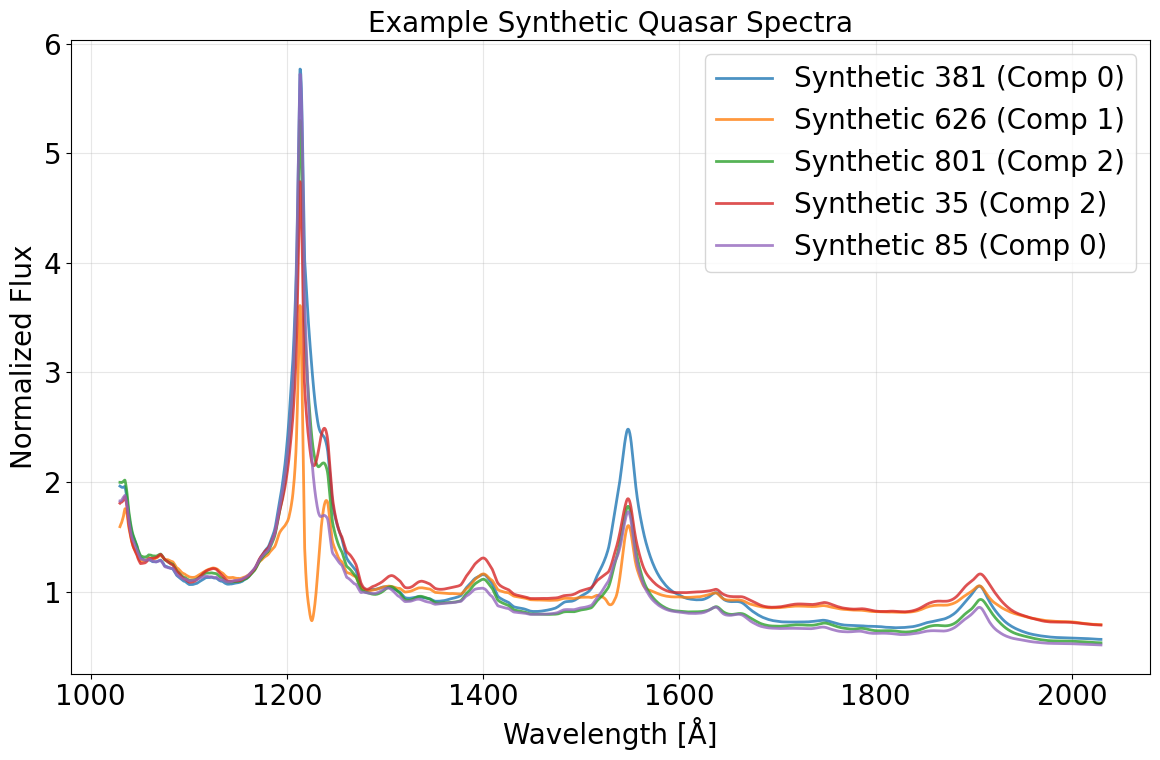

In [66]:
# Plot a few example synthetic spectra
fig, ax = plt.subplots(figsize=(12, 8))

n_examples = 5
indices = np.random.choice(n_synthetic, n_examples, replace=False)

for i, idx in enumerate(indices):
    component = component_labels[idx]
    ax.plot(wavelength, synthetic_spectra[idx], alpha=0.8, linewidth=2,
            label=f'Synthetic {idx} (Comp {component})')

ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel('Normalized Flux')
ax.set_title('Example Synthetic Quasar Spectra')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The individual synthetic spectra demonstrate realistic diversity. Each spectrum shows the characteristic quasar features—prominent emission lines superimposed on power-law continua—with variations in line strengths and continuum slopes that match the range seen in real data. The fact that spectra from different GMM components (indicated in the legend) show overlapping characteristics confirms our earlier observation that the components represent regions of a continuous distribution rather than distinct classes.

This successful generation of realistic mock spectra validates our modeling approach. The combination of PCA for dimensionality reduction and GMM for distribution modeling preserves the essential characteristics of quasar spectra while operating in a much lower-dimensional space.

## Outlier Detection with Gaussian Mixture Models

One powerful application of probabilistic models like GMM is identifying outliers—objects that don't fit well within the learned distribution. In the context of quasar spectra, outliers might represent rare physical conditions, misclassified objects, data quality issues, or genuinely interesting phenomena worthy of detailed study.

### Mathematical Framework for Outlier Detection

The GMM provides a natural framework for outlier detection through the likelihood function. For a quasar with PCA coefficients $\mathbf{z}$, the likelihood under our trained model is:

$$p(\mathbf{z}|\Theta) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{z}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$$

where $\Theta = \{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}_{k=1}^K$ represents the model parameters.

In practice, we work with log-likelihoods to avoid numerical underflow:

$$\log p(\mathbf{z}|\Theta) = \log \left( \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{z}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \right)$$

Objects with low log-likelihood are statistical outliers—they lie in regions of PCA space that the model assigns low probability density. Unlike simple distance-based methods, this approach naturally accounts for the covariance structure. An object might be far from any component mean but still have high likelihood if it lies along a direction of large variance.

### Implementing GMM-Based Outlier Detection

Let's implement outlier detection by computing log-likelihoods for all quasars in our dataset and identifying those with unusually low values:

In [67]:
def compute_log_likelihood(X, weights, means, covariances):
    """
    Compute log-likelihood for each sample under the GMM
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    weights : array, shape (k,)
        Mixture weights
    means : array, shape (k, n_features)
        Component means
    covariances : array, shape (k, n_features, n_features)
        Component covariances
    
    Returns:
    --------
    log_likelihoods : array, shape (n_samples,)
        Log-likelihood for each sample
    """
    n_samples = X.shape[0]
    k = len(weights)
    
    # Compute probability for each component
    component_probs = np.zeros((n_samples, k))
    
    for i in range(k):
        component_probs[:, i] = weights[i] * multivariate_gaussian_pdf(X, means[i], covariances[i])
    
    # Sum across components and take log
    total_probs = np.sum(component_probs, axis=1)
    log_likelihoods = np.log(np.maximum(total_probs, 1e-300))  # Avoid log(0)
    
    return log_likelihoods

# Calculate log-likelihoods for all data points
log_likelihoods_all = compute_log_likelihood(X_pca, weights_final, means_final, covariances_final)

# Determine outlier threshold using percentiles
outlier_percentile = 1  # Bottom 1% as outliers
threshold = np.percentile(log_likelihoods_all, outlier_percentile)

# Identify outliers
is_outlier = log_likelihoods_all < threshold
n_outliers = np.sum(is_outlier)
outlier_indices = np.where(is_outlier)[0]

print(f"Number of outliers (bottom {outlier_percentile}%): {n_outliers}")
print(f"Log-likelihood threshold: {threshold:.2f}")
print(f"Log-likelihood range: [{log_likelihoods_all.min():.2f}, {log_likelihoods_all.max():.2f}]")


Number of outliers (bottom 1%): 10
Log-likelihood threshold: -25.32
Log-likelihood range: [-41.20, -10.11]


Let's visualize where the outliers lie in PCA space relative to the learned GMM components:

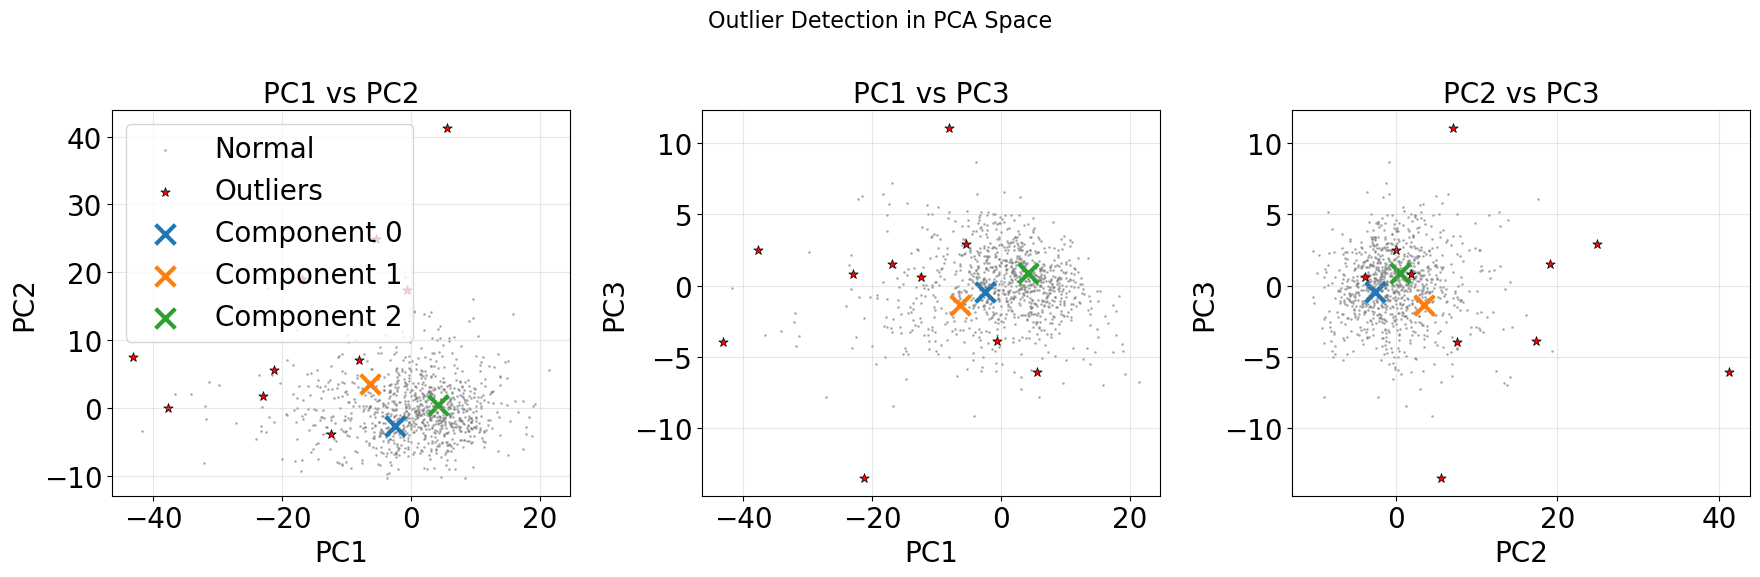

In [68]:
# Visualize outliers in PCA space
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Different PC pairs to show multiple views
pc_pairs = [(0, 1), (0, 2), (1, 2)]
titles = ['PC1 vs PC2', 'PC1 vs PC3', 'PC2 vs PC3']

for idx, ((pc1, pc2), title) in enumerate(zip(pc_pairs, titles)):
    ax = axes[idx]
    
    # Plot normal points
    normal_mask = ~is_outlier
    ax.scatter(X_pca[normal_mask, pc1], X_pca[normal_mask, pc2], 
              c='gray', s=1, alpha=0.5, label='Normal')
    
    # Plot outliers
    ax.scatter(X_pca[is_outlier, pc1], X_pca[is_outlier, pc2], 
              c='red', s=50, marker='*', label='Outliers', 
              edgecolors='black', linewidth=0.5)
    
    # Add GMM component centers
    for i in range(optimal_k):
        ax.scatter(means_final[i, pc1], means_final[i, pc2], 
                  c=f'C{i}', s=200, marker='x', linewidth=3,
                  label=f'Component {i}' if idx == 0 else None)
    
    ax.set_xlabel(f'PC{pc1+1}')
    ax.set_ylabel(f'PC{pc2+1}')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    if idx == 0:
        ax.legend()

plt.suptitle('Outlier Detection in PCA Space', fontsize=16)
plt.tight_layout()
plt.show()


The visualization reveals that outliers (red stars) tend to lie in the low-density regions of PCA space, away from the cores of the GMM components (marked by colored crosses). These points occupy the tails of the distribution where the model assigns low probability density. The fact that outliers appear in various locations across different PC projections indicates they can be unusual along multiple dimensions simultaneously.

This spatial distribution confirms that our likelihood-based detection successfully identifies spectra that are statistically rare according to our model. The outliers represent unusual combinations of the principal components—and thus unusual spectral features—that occur infrequently in the overall population.

### Examining Outlier Spectra

To understand what makes these quasars unusual, let's examine their spectra in the original wavelength space:


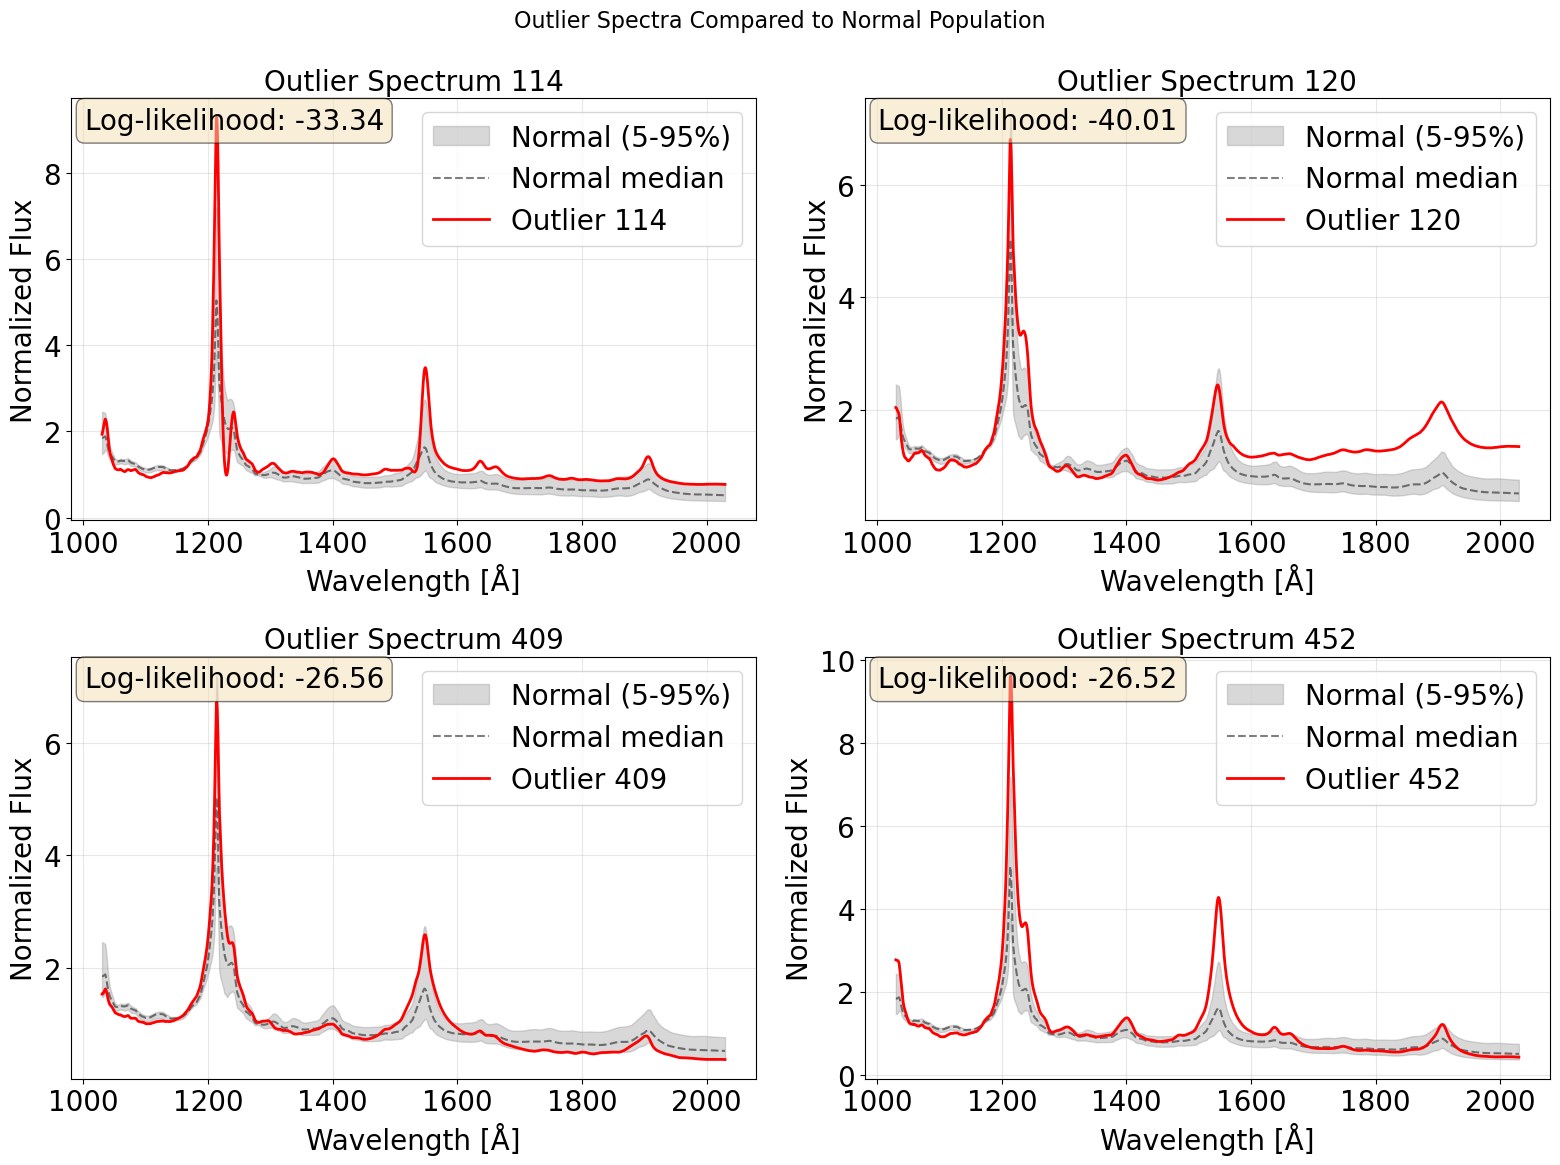

In [69]:
# Calculate statistics for normal spectra
normal_spectra = X[~is_outlier]
percentiles_2sigma = [5, 50, 95]
normal_percentiles = np.percentile(normal_spectra, percentiles_2sigma, axis=0)
normal_lower_2sigma = normal_percentiles[0]
normal_median = normal_percentiles[1]
normal_upper_2sigma = normal_percentiles[2]

# Plot outlier spectra against the normal range
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Select a few outliers to examine in detail
n_examples = min(4, n_outliers)
example_outliers = outlier_indices[:n_examples]

for i, (ax, outlier_idx) in enumerate(zip(axes, example_outliers)):
    # Plot 2-sigma range of normal spectra
    ax.fill_between(wavelength, normal_lower_2sigma, normal_upper_2sigma,
                   alpha=0.3, color='gray', label='Normal (5-95%)')
    ax.plot(wavelength, normal_median, 'k--', alpha=0.5, label='Normal median')
    
    # Plot the outlier spectrum
    outlier_spectrum = X[outlier_idx]
    ax.plot(wavelength, outlier_spectrum, 'r-', linewidth=2,
            label=f'Outlier {outlier_idx}')
    
    # Add log-likelihood information
    ll = log_likelihoods_all[outlier_idx]
    ax.text(0.02, 0.98, f'Log-likelihood: {ll:.2f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Wavelength [Å]')
    ax.set_ylabel('Normalized Flux')
    ax.set_title(f'Outlier Spectrum {outlier_idx}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle('Outlier Spectra Compared to Normal Population', fontsize=16)
plt.tight_layout()
plt.show()


The outlier spectra reveal dramatic deviations from the normal population, particularly in their emission line strengths. All four examples show Lyα emission at 1215 Å that far exceeds the 95th percentile of normal quasars, with peak fluxes reaching 6-9 times the normalized continuum level compared to typical values of 2-3. Several outliers also exhibit unusually strong C IV emission at 1549 Å and other metal lines.

The extremely negative log-likelihoods (ranging from -26 to -40) confirm that these spectra represent highly improbable configurations under our GMM. The fact that the continuum shapes generally fall within the normal range while the emission lines are extreme suggests these outliers are characterized by unusual line-to-continuum ratios rather than strange continuum properties.

These outliers could represent:
- Quasars with unusual broad-line region properties (extreme covering factors or ionization states)
- Objects with peculiar viewing angles that enhance emission line visibility
- Potential data processing artifacts that artificially boost emission features
- Genuinely rare objects that warrant follow-up investigation

The success of our outlier detection demonstrates the value of combining dimensionality reduction with probabilistic modeling. By learning the typical patterns of spectral variation through PCA and GMM, we can automatically flag objects that deviate significantly from these patterns, enabling efficient identification of rare or problematic spectra in large surveys.

## Summary

This tutorial has demonstrated the power of combining dimensionality reduction with probabilistic modeling for astronomical data analysis. Through the analysis of quasar spectra, we've explored several key concepts that extend throughout statistical machine learning in astronomy:

**Extreme Dimensionality Reduction**: We successfully compressed thousands of spectral dimensions to just a handful of principal components while preserving the vast majority of the variance. This dramatic compression illustrates the potential for efficient data representation when the underlying physics constrains the effective dimensionality of the data.

**Interpretable Components**: The principal components revealed clear physical meaning. The first component captured overall emission line strength variations, the second encoded continuum power-law slopes, and higher components represented more subtle line ratio variations. This interpretability makes PCA not just a compression tool but a method for understanding the dominant modes of astrophysical variation.

**Probabilistic Modeling**: Our Gaussian Mixture Model, selected through careful analysis using the Bayesian Information Criterion, successfully captured the distribution of quasars in PCA space. The overlapping components reflect the continuous nature of quasar properties rather than distinct classes.

**Generative Capabilities**: The GMM successfully generates realistic synthetic quasar spectra that match the statistical properties of the training data. This capability enables the creation of large mock catalogs for testing analysis pipelines or augmenting limited observational datasets.

**Anomaly Detection**: By identifying objects with low likelihood under the GMM, we discovered genuinely unusual spectra characterized by extreme emission line strengths. These outliers represent rare configurations that warrant further investigation and demonstrate the value of probabilistic approaches for finding interesting objects in large surveys.

The techniques developed here—PCA for dimensionality reduction, GMM for distribution modeling, and likelihood-based outlier detection—form a powerful toolkit for unsupervised analysis of high-dimensional astronomical data. While demonstrated on simulated quasar spectra, these methods readily extend to real observational data from surveys like SDSS, DESI, or Euclid, where they can help uncover new insights about the diversity of astronomical objects and identify rare phenomena worthy of detailed study.